In [45]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook


### HGNC Mapper

In [2]:
hgnc = pd.read_csv('../../data/hgnc_alias_list.txt', sep='\t')
hgnc.head()

hgnc = hgnc[hgnc['Approved symbol'].apply(lambda x: 'withdrawn' not in x)]

# get the original keys
hgnc_original_keys = hgnc['Approved symbol'].unique()

# drop a lot of columns for efficiency
hgnc = hgnc[list(hgnc.columns)[0:6]].drop('Status', axis=1)

# filter out Nan synonyms (not helpful)
hgnc_syn_list = hgnc[~ hgnc.Synonyms.isna()]
hgnc_prev_symb_list = hgnc[~ hgnc['Previous symbols'].isna()]

print(hgnc_syn_list.shape)
print(hgnc_syn_list.columns)
display(hgnc_syn_list.head())

print(hgnc_prev_symb_list.shape)
print(hgnc_prev_symb_list.columns)
display(hgnc_prev_symb_list.head())

#convert the synonyms column to a list
# convert these lists to pd.Series
# merge with original dataframe
#drop old synonyms column 
# melt the new columns into rows


current_syn_list = hgnc_syn_list.Synonyms.apply(lambda x: x.split(',')) \
    .apply(pd.Series) \
    .merge(hgnc, left_index = True, right_index = True) \
    .drop(["Synonyms"], axis = 1) \
    .melt(id_vars = ['HGNC ID', 'Approved symbol', 'Approved name', 'Previous symbols'], value_name = "synonym") 

current_syn_list = current_syn_list[~ current_syn_list.synonym.isna()]
current_syn_list.synonym = current_syn_list.synonym.apply(lambda x: x.replace(' ',''))

prev_symb_list = hgnc_prev_symb_list['Previous symbols'].apply(lambda x: x.split(',')) \
    .apply(pd.Series) \
    .merge(hgnc, left_index = True, right_index = True) \
    .drop(['Previous symbols'], axis = 1) \
    .melt(id_vars = ['HGNC ID', 'Approved symbol', 'Approved name', 'Synonyms'], value_name = "synonym") 

prev_symb_list = prev_symb_list[~ prev_symb_list.synonym.isna()]
prev_symb_list.synonym = prev_symb_list.synonym.apply(lambda x: x.replace(' ',''))


hgnc_mapper = dict(zip(current_syn_list['synonym'], current_syn_list['Approved symbol']))
# add in HGNC ID mapper
hgnc_mapper.update(dict(zip(current_syn_list['HGNC ID'], current_syn_list['Approved symbol'])))
hgnc_mapper_previous = dict(zip(prev_symb_list['synonym'], prev_symb_list['Approved symbol']))

trouble_list = list(filter(lambda x: hgnc_mapper[x] != hgnc_mapper_previous[x], set(hgnc_mapper.keys())&set(hgnc_mapper_previous.keys())))

louvain_tier1 = pd.read_csv('../../results/louvain_clusters.txt', sep='\t')
for n in louvain_tier1.names:
    if (n in trouble_list):
        print(n)

hand_coded = {'RAGE':'MOK', 'SGK2':'SGK2', 'SGK196':'SGK196'}

hgnc_mapper_previous.update(hgnc_mapper) #overwrite the previous symbol conflicts

hgnc_mapper = hgnc_mapper_previous
hgnc_mapper.update({x:x for x in hgnc_original_keys}) #keep the identify maps
hgnc_mapper.update(hand_coded) # overwrite the trouble list

(21435, 5)
Index(['HGNC ID', 'Approved symbol', 'Approved name', 'Previous symbols',
       'Synonyms'],
      dtype='object')


HGNC ID Approved symbol                      Approved name  \
1   HGNC:37133        A1BG-AS1               A1BG antisense RNA 1   
2   HGNC:24086            A1CF     APOBEC1 complementation factor   
4       HGNC:7             A2M              alpha-2-macroglobulin   
6   HGNC:23336           A2ML1       alpha-2-macroglobulin like 1   
12  HGNC:30005         A3GALT2  alpha 1,3-galactosyltransferase 2   

               Previous symbols                           Synonyms  
1   NCRNA00181, A1BGAS, A1BG-AS                           FLJ23569  
2                           NaN  ACF, ASP, ACF64, ACF65, APOBEC1CF  
4                           NaN             FWP007, S863-7, CPAMD5  
6                        CPAMD9                     FLJ25179, p170  
12                     A3GALT2P                      IGBS3S, IGB3S

(11702, 5)
Index(['HGNC ID', 'Approved symbol', 'Approved name', 'Previous symbols',
       'Synonyms'],
      dtype='object')


HGNC ID Approved symbol  \
1   HGNC:37133        A1BG-AS1   
6   HGNC:23336           A2ML1   
9       HGNC:8           A2MP1   
12  HGNC:30005         A3GALT2   
13  HGNC:18149          A4GALT   

                                      Approved name  \
1                              A1BG antisense RNA 1   
6                      alpha-2-macroglobulin like 1   
9                alpha-2-macroglobulin pseudogene 1   
12                alpha 1,3-galactosyltransferase 2   
13  alpha 1,4-galactosyltransferase (P blood group)   

               Previous symbols             Synonyms  
1   NCRNA00181, A1BGAS, A1BG-AS             FLJ23569  
6                        CPAMD9       FLJ25179, p170  
9                          A2MP                  NaN  
12                     A3GALT2P        IGBS3S, IGB3S  
13                           P1  A14GALT, Gb3S, P(k)

RAGE


### Import Louvain Clusters

In [3]:
louvain_tier1 = pd.read_csv('../../results/louvain_clusters.txt', sep='\t')
louvain_tier2 = pd.read_csv('../../results/louvain_small_clusters.txt', sep='\t')

louvain_tier1.names = louvain_tier1.names.apply(lambda x: hgnc_mapper[x])
louvain_tier2.names = louvain_tier2.names.apply(lambda x: hgnc_mapper[x])

louv = louvain_tier1.merge(louvain_tier2, on='names', suffixes=['_super','_sub'])
louv.head()

names  cluster_super  cluster_sub
0   PAK1              5            3
1  ERBB2              5           18
2  MST1R              5           18
3   YES1              5           18
4  TYRO3              5           18

### Import Drug Targeting

In [4]:
drug_data = pd.read_excel('../../data/Klaeger_Science_2017 Supplementary Table 6 Selectivities.xlsx', sheet_name='CATDS target')

# filter to only hgnc keys
drug_data = drug_data[drug_data.Target.isin(hgnc_mapper.keys())]

double_drug_targets = drug_data[drug_data['Target'].apply(lambda x: ';' in x)]
#double_drug_targets.shape

first_genes = double_drug_targets['Target'].apply(lambda x: x.split(';')[0])
second_genes = double_drug_targets['Target'].apply(lambda x: x.split(';')[1])

repaired_double_targets = double_drug_targets.drop('Target', axis=1).assign(**{'Target':first_genes})
repaired_double_targets = repaired_double_targets.append(double_drug_targets.drop('Target', axis=1).assign(**{'Target':second_genes})) 
#repaired_double_targets = repaired_double_targets[cols_to_keep]

drug_data = drug_data.drop(double_drug_targets.index).append(repaired_double_targets)

# convert to hgnc
drug_data.Target = drug_data.Target.apply(lambda x: hgnc_mapper[x])

# sort columns
drug_data = drug_data[['Target', 'Drug', 'At', 'CATDS']]
drug_data = drug_data[drug_data.Target.isin(set(louv['names']))]
drug_data.head()


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Target        Drug        At     CATDS
0     AURKA     MK-5108  0.120921  0.657165
1     CHEK1   PF-477736  0.243725  0.733257
2      FLT3   Dovitinib  0.265240  0.860803
4       MET  Capmatinib  0.337514  1.000000
5  MAPKAPK2      VX-702  0.342705  0.743594

In [5]:
kin_drug_sets = drug_data.groupby('Target').agg({'Drug':list})
kin_drug_sets = kin_drug_sets.reindex(louv.set_index('names').index)
louv = louv.merge(kin_drug_sets, on='names')
#louv.head()
#kin_drug_sets

### Import Understudied

In [6]:
understudied = pd.read_csv('../../data/dark_kinases.csv')
understudied.head()
#louv['']

hgnc_id symbol  ensembl_gene_id class                             name  \
0  HGNC:19038  ADCK1  ENSG00000063761  Dark  aarF domain containing kinase 1   
1  HGNC:19039  ADCK2  ENSG00000133597  Dark  aarF domain containing kinase 2   
2  HGNC:21738  ADCK5  ENSG00000173137  Dark  aarF domain containing kinase 5   
3  HGNC:20565  ALPK2  ENSG00000198796  Dark                   alpha kinase 2   
4  HGNC:17574  ALPK3  ENSG00000136383  Dark                   alpha kinase 3   

  uniprot_ids kinase_com_name  
0      Q86TW2           ADCK1  
1      Q7Z695           ADCK2  
2      Q3MIX3           ADCK5  
3      Q86TB3         AlphaK2  
4      Q96L96         AlphaK1

In [7]:
louv['understudied'] = louv['names'].isin(understudied['symbol'])
louv.head()

names  cluster_super  cluster_sub  \
0   PAK1              5            3   
1  ERBB2              5           18   
2  MST1R              5           18   
3   YES1              5           18   
4  TYRO3              5           18   

                                                Drug  understudied  
0                                                NaN         False  
1                                                NaN         False  
2  [Golvatinib, Crizotinib, Foretinib, MK-2461, O...         False  
3  [TG-100572, Dasatinib, TAK-901, Ibrutinib, Dan...         False  
4                                                NaN         False

In [8]:
from copy import copy
import itertools as it
subcluster_data = copy(louv.groupby('cluster_sub').agg({'cluster_super':np.mean,'names':len, 'understudied':lambda x: int(sum(x)), 'Drug':lambda x: list(filter(lambda y: y is not np.nan, list(x)))}))
subcluster_data.Drug = subcluster_data.Drug.apply(lambda x: list(it.chain.from_iterable(x)))
subcluster_data.head()

cluster_super  names  understudied  \
cluster_sub                                       
1                        4      2             2   
2                        7     30             4   
3                        5      8             2   
4                        2     41             1   
5                        5      8             0   

                                                          Drug  
cluster_sub                                                     
1            [PF-3758309, Lestaurtinib, OTS-167, Sunitinib,...  
2            [GDC-0994, Ulixertinib, PHA-793887, PF-477736,...  
3            [Dasatinib, Ponatinib, Gilteritinib, Rebastini...  
4            [Dasatinib, Ponatinib, Bosutinib, BI-847325, F...  
5            [Sotrastaurin, Ruboxistaurin, UCN-01, Decernot...

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
tfidf = TfidfVectorizer(lowercase=False, tokenizer=lambda x: x.split(','))
output = tfidf.fit_transform(raw_documents=subcluster_data['Drug'].apply(lambda x: ','.join(x)))
output

<36x218 sparse matrix of type '<class 'numpy.float64'>'
	with 1533 stored elements in Compressed Sparse Row format>

In [32]:
drug_tfidf = pd.DataFrame(output.toarray(), index=subcluster_data.index, columns=tfidf.get_feature_names())
drug_tfidf.drop('', axis=1, inplace=True)
drug_tfidf.head()

AC-480  ACTB-1003   AEE-788   AEW-541  AMG-208   AMG-900  \
cluster_sub                                                             
1               0.0   0.000000  0.000000  0.000000      0.0  0.000000   
2               0.0   0.120005  0.000000  0.109427      0.0  0.174847   
3               0.0   0.000000  0.153086  0.000000      0.0  0.159352   
4               0.0   0.048640  0.000000  0.088705      0.0  0.042521   
5               0.0   0.000000  0.000000  0.000000      0.0  0.140278   

             ARRY-380  ASP-3026  AT-13148   AT-7519    ...     Vandetanib  \
cluster_sub                                            ...                  
1                 0.0  0.000000  0.000000  0.000000    ...            0.0   
2                 0.0  0.028091  0.000000  0.042112    ...            0.0   
3                 0.0  0.256012  0.000000  0.000000    ...            0.0   
4                 0.0  0.068314  0.051206  0.102412    ...            0.0   
5                 0.0  0.056342  0.084464  0.000000    ...            0.0   

             Varlitinib  Vatalanib  Vemurafenib  Volasertib  X-396    XL-019  \
cluster_sub                                                                    
1                   0.0        0.0     0.000000         0.0    0.0  0.000000   
2                   0.0        0.0     0.084223         0.0    0.0  0.031159   
3                   0.0        0.0     0.000000         0.0    0.0  0.000000   
4                   0.0        0.0     0.000000         0.0    0.0  0.000000   
5                   0.0        0.0     0.000000         0.0    0.0  0.124991   

               XL-228  XL-413   Y-39983  
cluster_sub                              
1            0.197886     0.0  0.000000  
2            0.076568     0.0  0.032330  
3            0.116304     0.0  0.000000  
4            0.062069     0.0  0.157246  
5            0.153573     0.0  0.194533  

[5 rows x 217 columns]

In [34]:
drug_score = drug_tfidf.sum(axis=1) 
drug_score

cluster_sub
1      3.926111
2      8.197833
3      5.449550
4      8.339897
5      7.186975
6      9.565995
7      5.264555
8      5.348649
9      9.986641
10     6.071755
11     8.442926
12     9.431016
13     7.532303
14     0.000000
15     0.000000
16     4.700926
17     5.899515
18    10.191481
19     1.000000
20     4.939538
21     4.059190
22     4.019307
23     2.910020
24     7.009435
25     5.228162
26     0.000000
27     4.306810
28     0.000000
29     2.496789
30     1.879738
31     1.999165
32     0.000000
33     7.309061
34     0.000000
35     5.396099
36     2.367330
dtype: float64

In [35]:
subcluster_data['drug_score'] = drug_score
subcluster_data.head()

cluster_super  names  understudied  \
cluster_sub                                       
1                        4      2             2   
2                        7     30             4   
3                        5      8             2   
4                        2     41             1   
5                        5      8             0   

                                                          Drug  drug_score  
cluster_sub                                                                 
1            [PF-3758309, Lestaurtinib, OTS-167, Sunitinib,...    3.926111  
2            [GDC-0994, Ulixertinib, PHA-793887, PF-477736,...    8.197833  
3            [Dasatinib, Ponatinib, Gilteritinib, Rebastini...    5.449550  
4            [Dasatinib, Ponatinib, Bosutinib, BI-847325, F...    8.339897  
5            [Sotrastaurin, Ruboxistaurin, UCN-01, Decernot...    7.186975

<IPython.core.display.Javascript object>


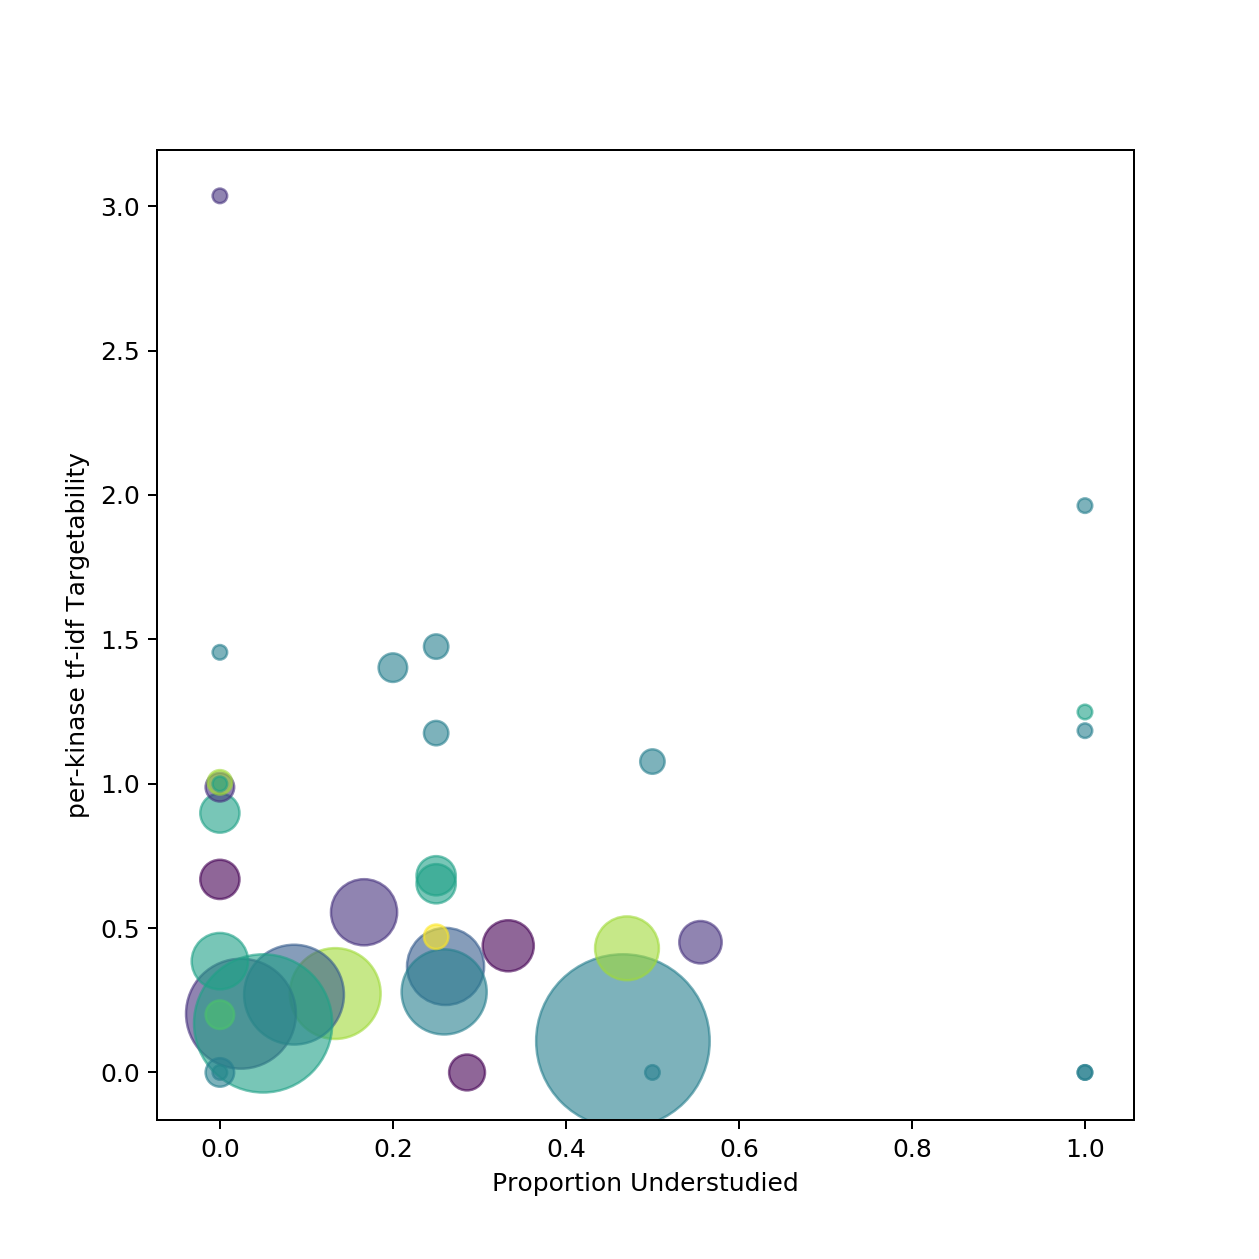

In [58]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
plt.scatter(x=subcluster_data['understudied']/subcluster_data['names'], y=subcluster_data['drug_score']/subcluster_data['names'], s=subcluster_data['names'].apply(lambda x: (np.log(x)+1)*x*10), c=subcluster_data['cluster_super'], alpha=.6)
plt.xlabel('Proportion Understudied')
plt.ylabel('per-kinase tf-idf Targetability')
#ax.set_yscale("log", basey=2)#, nonposy='clip')
#plt.ylim([-2,4])
plt.show()

<IPython.core.display.Javascript object>


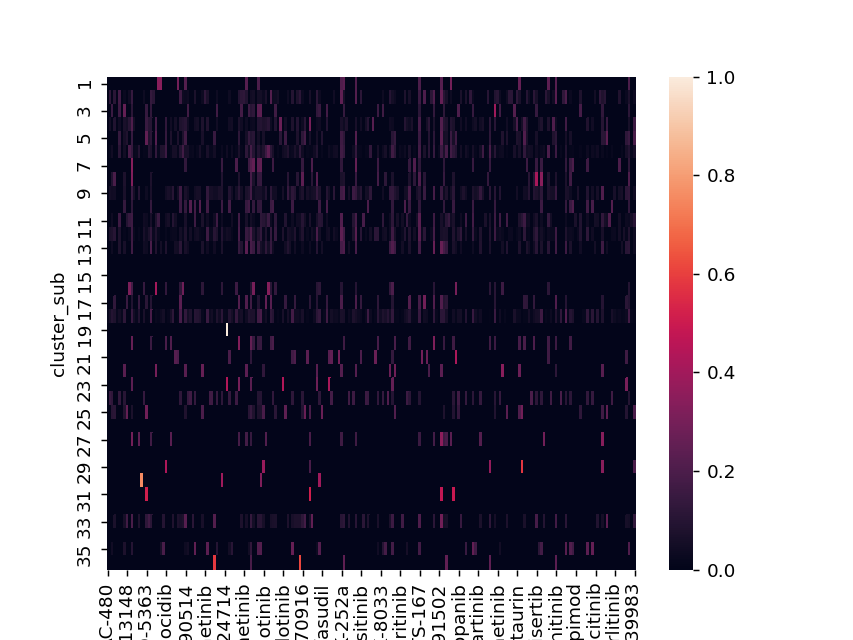

In [288]:
fig, ax = plt.subplots()
sns.heatmap(drug_tfidf)

In [77]:
drug_tfidf.dropna(axis=1)

AC-480  ACTB-1003   AEE-788   AEW-541   AMG-208   AMG-900  \
cluster_sub                                                                
1            0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
2            0.000000   0.120005  0.000000  0.109427  0.000000  0.174847   
3            0.000000   0.000000  0.153086  0.000000  0.000000  0.159352   
4            0.000000   0.048640  0.000000  0.088705  0.000000  0.042521   
5            0.000000   0.000000  0.000000  0.000000  0.000000  0.140278   
6            0.000000   0.018016  0.045391  0.000000  0.000000  0.110247   
7            0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
8            0.000000   0.000000  0.089824  0.195055  0.000000  0.000000   
9            0.000000   0.049904  0.041911  0.045505  0.000000  0.000000   
10           0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
11           0.000000   0.000000  0.037652  0.000000  0.000000  0.156770   
12           0.000000   0.067053  0.075085  0.101905  0.000000  0.078158   
13           0.000000   0.000000  0.038387  0.000000  0.000000  0.079915   
14           0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
15           0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
16           0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
17           0.000000   0.000000  0.000000  0.131098  0.000000  0.000000   
18           0.022198   0.057372  0.096366  0.078472  0.022198  0.050155   
19           0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
20           0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
21           0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
22           0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
23           0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
24           0.000000   0.150335  0.126256  0.000000  0.000000  0.131423   
25           0.000000   0.000000  0.102538  0.111331  0.000000  0.000000   
26           0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
27           0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
28           0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
29           0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
30           0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
31           0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
32           0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
33           0.000000   0.000000  0.000000  0.072823  0.000000  0.000000   
34           0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
35           0.000000   0.000000  0.045701  0.000000  0.000000  0.000000   
36           0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   

             ARRY-380  ASP-3026  AT-13148   AT-7519    ...     Vandetanib  \
cluster_sub                                            ...                  
1            0.000000  0.000000  0.000000  0.000000    ...       0.000000   
2            0.000000  0.028091  0.000000  0.042112    ...       0.000000   
3            0.000000  0.256012  0.000000  0.000000    ...       0.000000   
4            0.000000  0.068314  0.051206  0.102412    ...       0.000000   
5            0.000000  0.056342  0.084464  0.000000    ...       0.000000   
6            0.000000  0.050606  0.000000  0.189663    ...       0.020063   
7            0.000000  0.000000  0.000000  0.000000    ...       0.000000   
8            0.000000  0.075108  0.000000  0.000000    ...       0.000000   
9            0.000000  0.070089  0.000000  0.000000    ...       0.000000   
10           0.000000  0.137842  0.000000  0.000000    ...       0.218595   
11           0.000000  0.000000  0.094394  0.141592    ...       0.000000   
12           0.000000  0.015696  0.000000  0.023530    ...       0.024891   
13           0.000000  0.064195  0.000000  0.000

In [81]:
idf = drug_tfidf[drug_tfidf>0].min(axis=0)
idf

AC-480         0.022198
ACTB-1003      0.018016
AEE-788        0.037652
AEW-541        0.045505
AMG-208        0.022198
AMG-900        0.042521
ARRY-380       0.022198
ASP-3026       0.015696
AT-13148       0.051206
AT-7519        0.023530
AT-9283        0.073304
AV-412         0.020063
AZD-1208       0.019900
AZD-1480       0.022351
AZD-2014       0.761083
AZD-4547       0.017178
AZD-5363       0.011172
AZD-5438       0.015100
AZD-7762       0.062966
AZD-8330       0.031011
Abemaciclib    0.026157
Afatinib       0.015973
Alectinib      0.031946
Alisertib      0.051018
Alvocidib      0.019539
Apatinib       0.018270
Apitolisib     0.017178
Axitinib       0.023530
BGT-226        0.023530
BI-2536        0.013676
                 ...   
TAK-733        0.123815
TAK-901        0.031483
TG-100115      0.018270
TG-100572      0.014033
TG-100801      0.018966
Talmapimod     0.069384
Tandutinib     0.031011
Tanzisertib    0.018016
Telatinib      0.022198
Tepotinib      0.022198
Tesevatinib    0

In [87]:
drug_tfidf.loc[1:2]

AC-480  ACTB-1003  AEE-788   AEW-541  AMG-208   AMG-900  \
cluster_sub                                                            
1               0.0   0.000000      0.0  0.000000      0.0  0.000000   
2               0.0   0.120005      0.0  0.109427      0.0  0.174847   

             ARRY-380  ASP-3026  AT-13148   AT-7519   ...     Vandetanib  \
cluster_sub                                           ...                  
1                 0.0  0.000000       0.0  0.000000   ...            0.0   
2                 0.0  0.028091       0.0  0.042112   ...            0.0   

             Varlitinib  Vatalanib  Vemurafenib  Volasertib  X-396    XL-019  \
cluster_sub                                                                    
1                   0.0        0.0     0.000000         0.0    0.0  0.000000   
2                   0.0        0.0     0.084223         0.0    0.0  0.031159   

               XL-228  XL-413  Y-39983  
cluster_sub                             
1            0.197886     0.0  0.00000  
2            0.076568     0.0  0.03233  

[2 rows x 217 columns]

In [106]:
subcluster_data['cluster_super'].index == drug_tfidf.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [126]:
subcluster_data['cluster_super'].loc[1]

4

In [133]:
from umap import UMAP

In [285]:
red = UMAP()
out = red.fit_transform(drug_tfidf)

In [143]:
blue = TSNE()
out = blue.fit_transform(drug_tfidf)

In [142]:
from sklearn.manifold import TSNE

In [146]:
from sklearn.decomposition import PCA
green = PCA(n_components=2)
out = green.fit_transform(drug_tfidf)
display(green.explained_variance_ratio_)

array([0.14846649, 0.10770413])

<IPython.core.display.Javascript object>


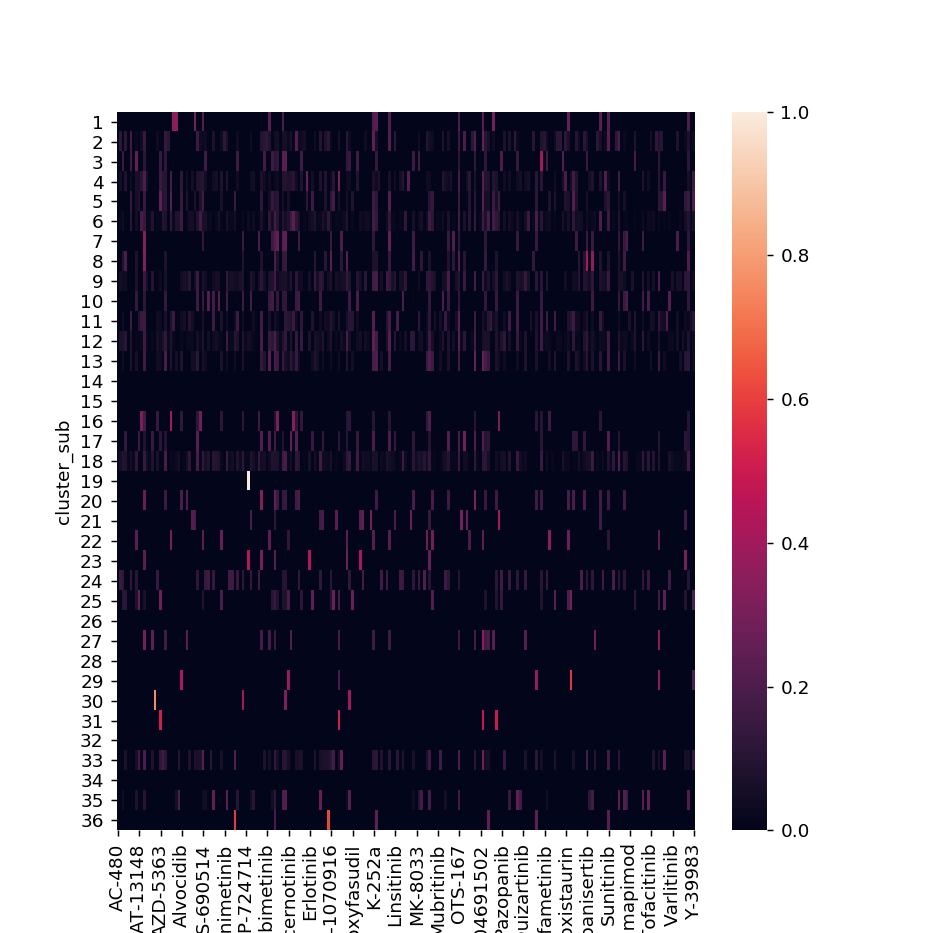

In [286]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
plt.scatter(out[:,0], out[:,1], c=subcluster_data['cluster_super'])

<IPython.core.display.Javascript object>


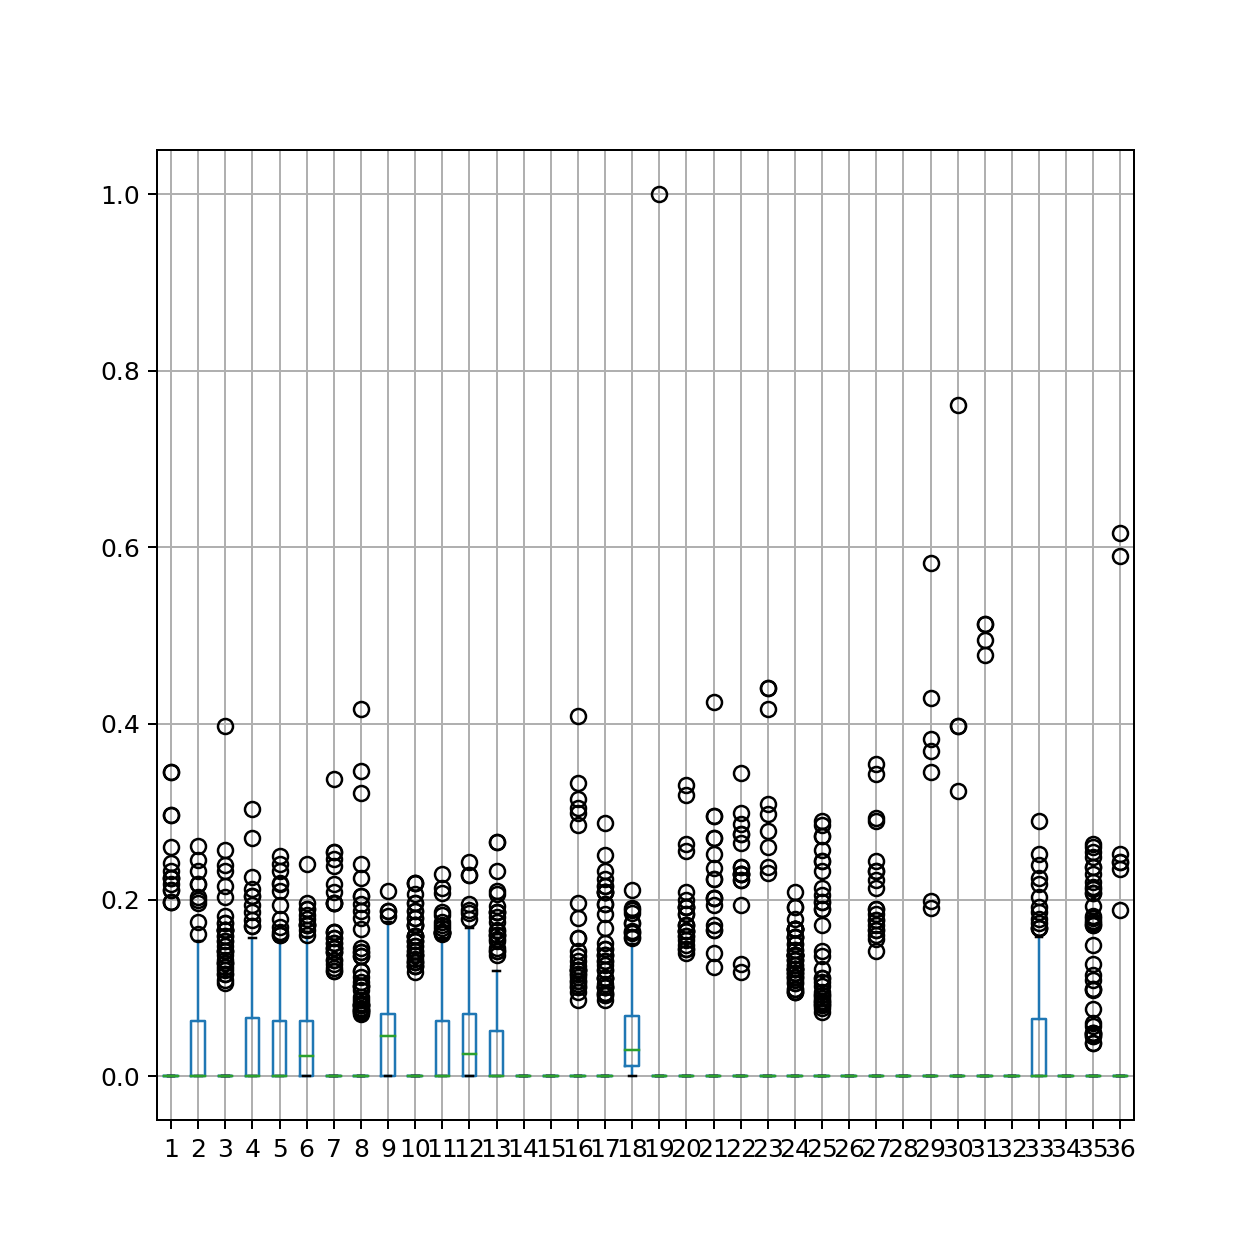

In [152]:
fig, ax = plt.subplots(figsize=(7,7), ncols=1, nrows=1)
pd.plotting.boxplot(drug_tfidf.transpose())
plt.show()

<IPython.core.display.Javascript object>


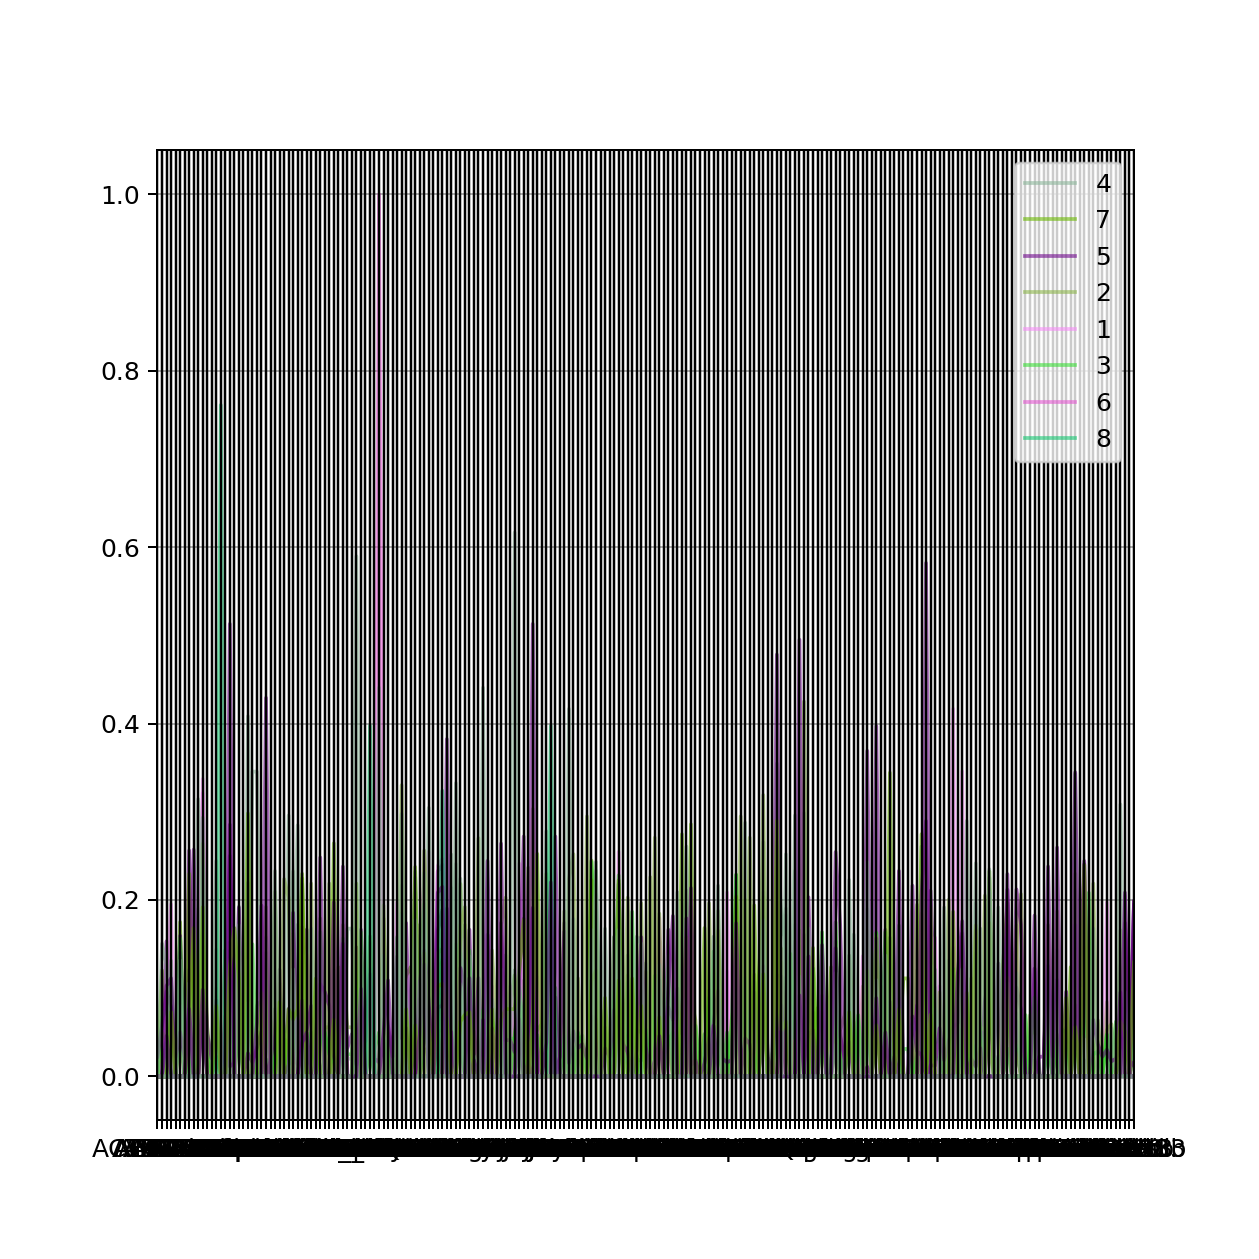

In [122]:
fig, ax = plt.subplots(figsize=(7,7), ncols=1, nrows=1)
pd.plotting.parallel_coordinates(pd.concat([drug_tfidf,subcluster_data['cluster_super']],axis=1), class_column='cluster_super', alpha=.6)
plt.show()

<IPython.core.display.Javascript object>


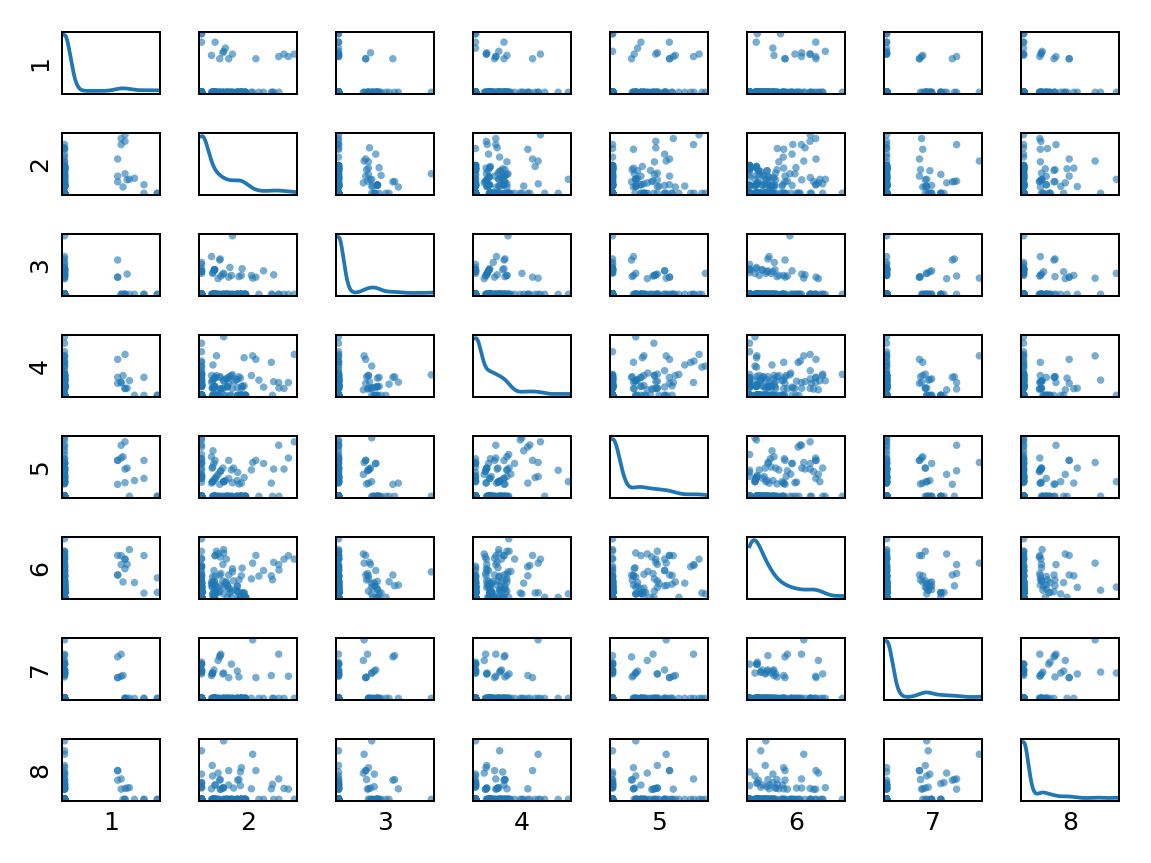

In [119]:
axes = pd.plotting.scatter_matrix(drug_tfidf.loc[1:8].transpose(), alpha=.6, diagonal='kde')
for row in axes:
    for ax in row:
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


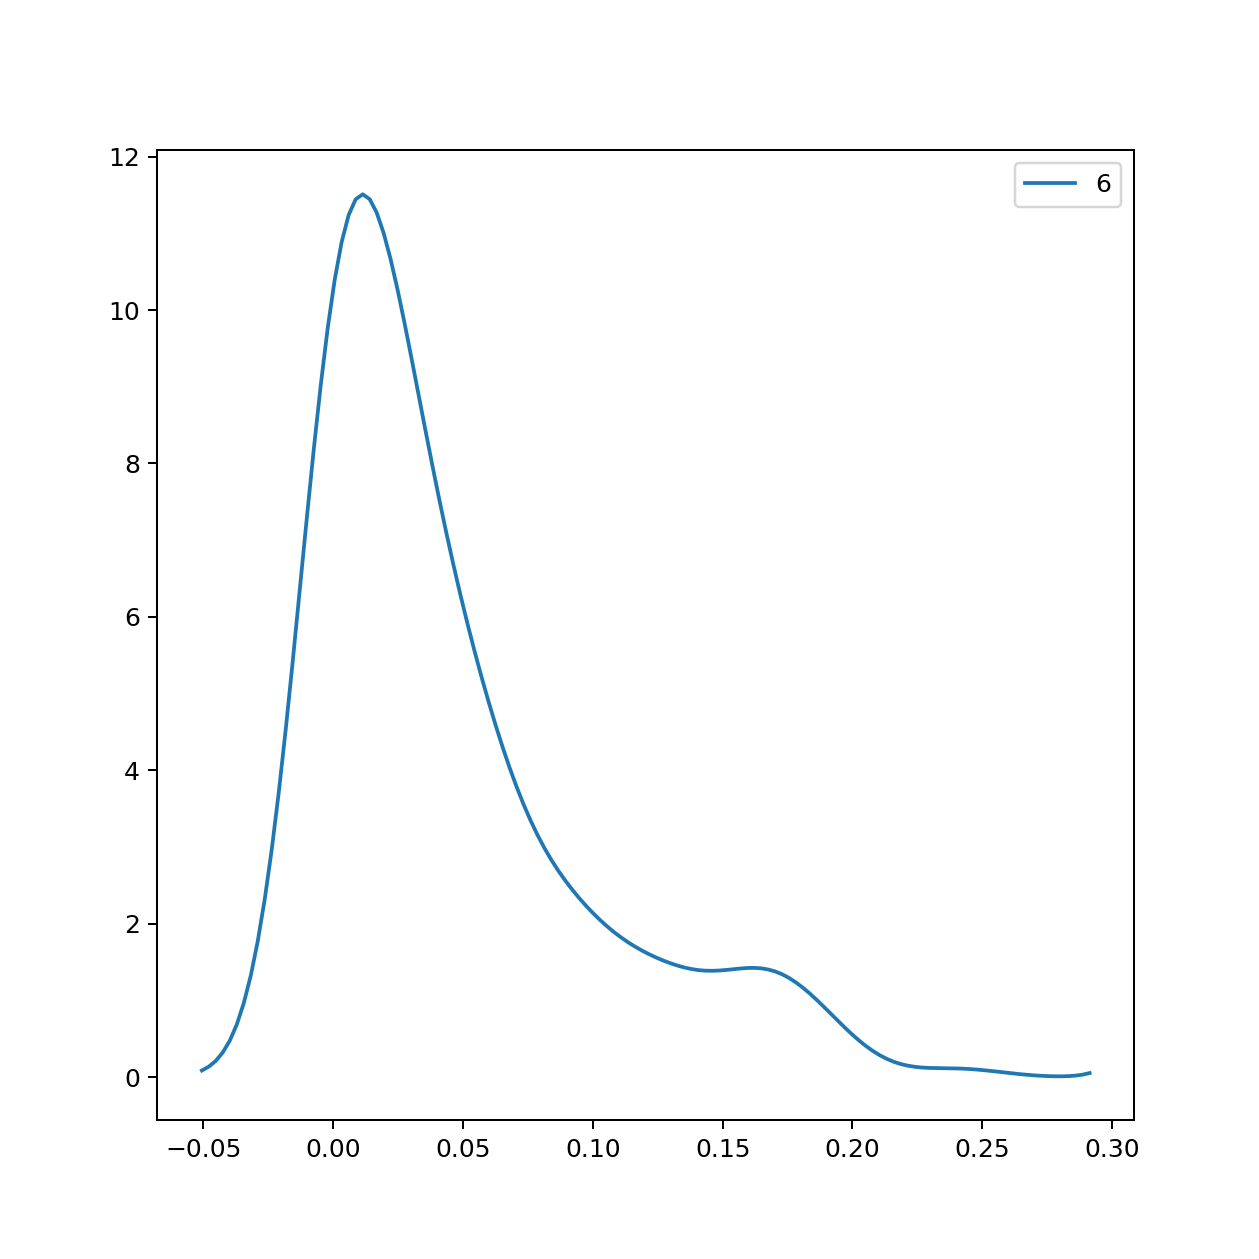

In [85]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
sns.kdeplot(data=drug_tfidf.loc[6])
plt.autoscale()
plt.show()

<IPython.core.display.Javascript object>


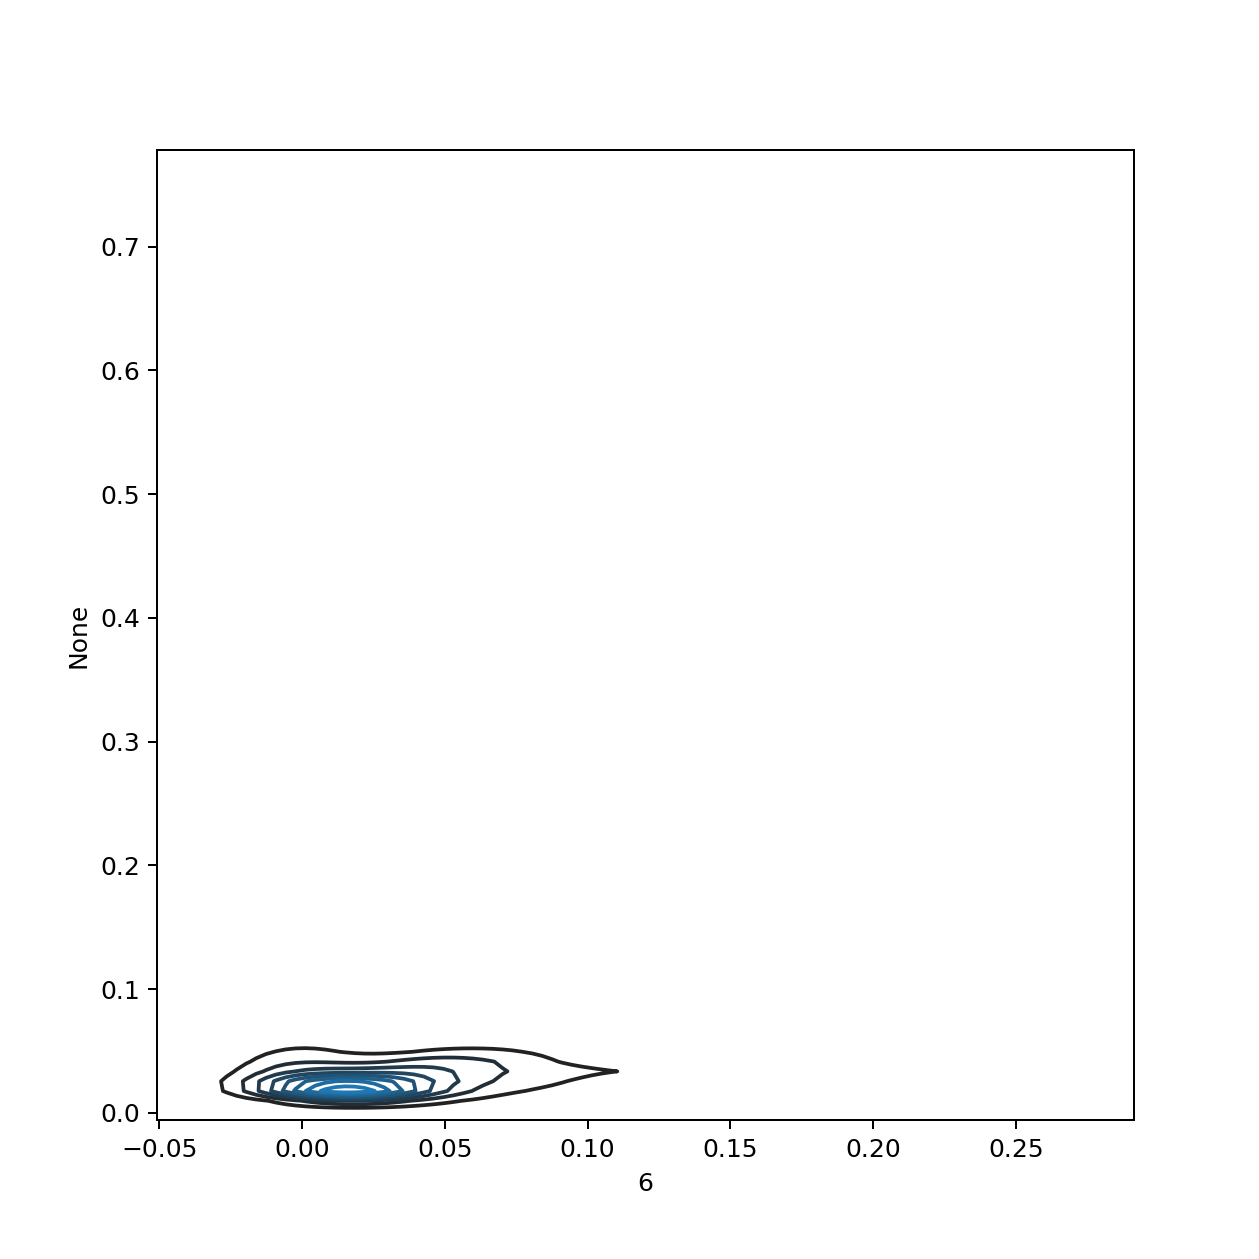

In [84]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
sns.kdeplot(data=drug_tfidf.loc[6], data2=idf)
plt.autoscale()
plt.show()

<IPython.core.display.Javascript object>


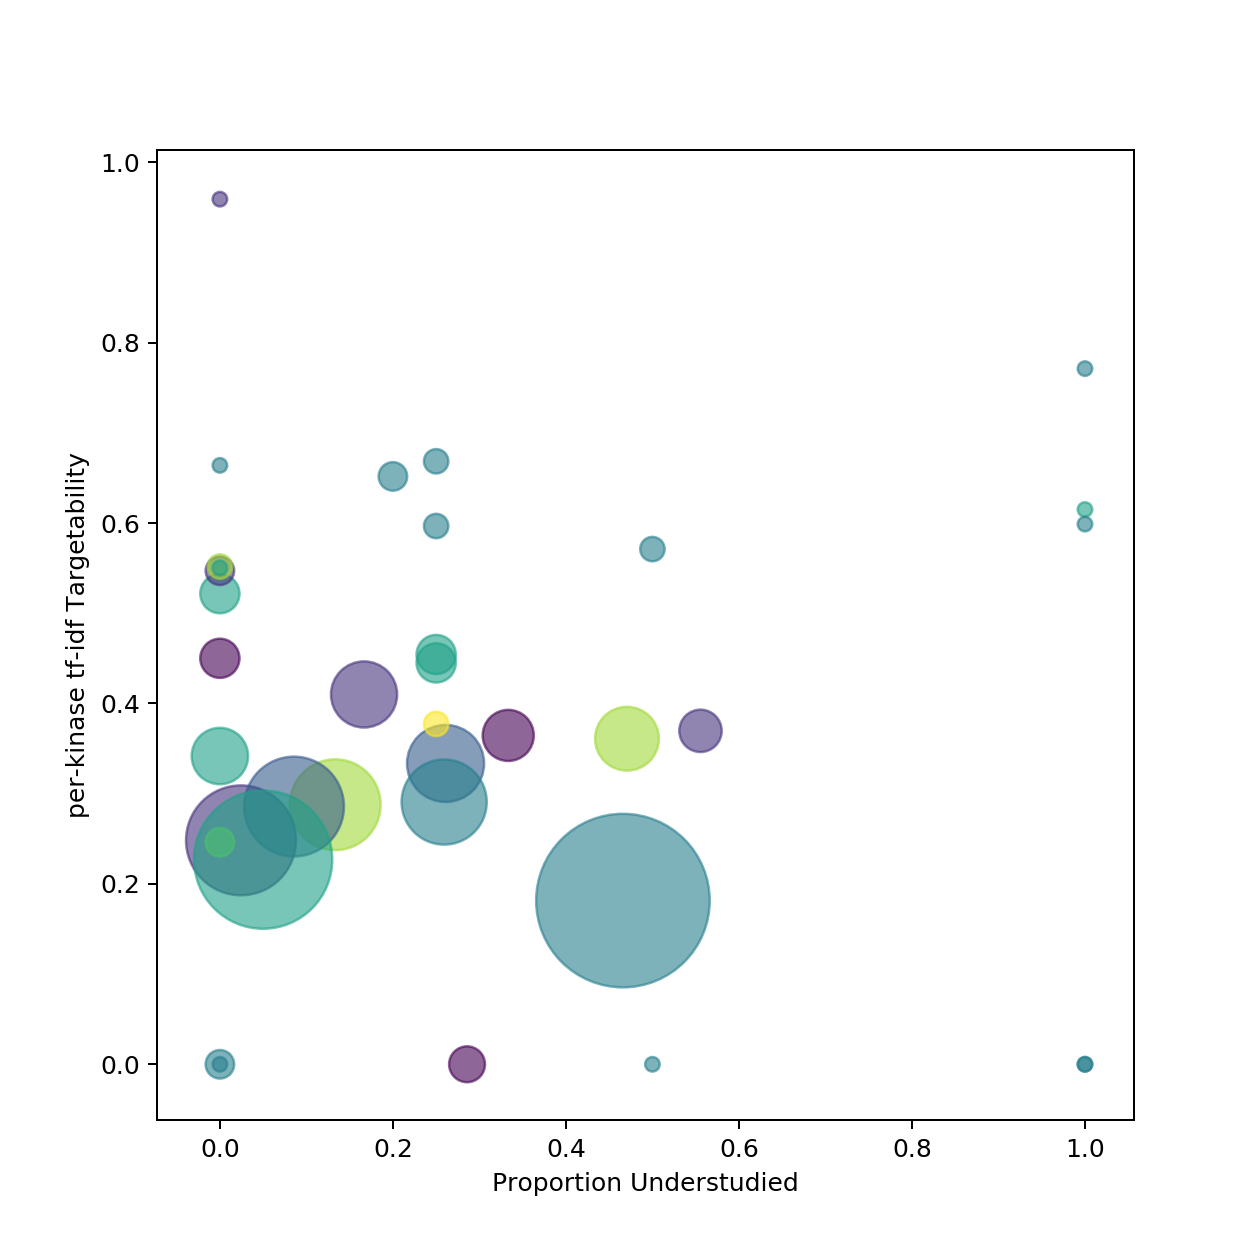

In [170]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
plt.scatter(x=subcluster_data['understudied']/subcluster_data['names'], y=np.sqrt(subcluster_data['drug_score']/subcluster_data['names']/3.3), s=subcluster_data['names'].apply(lambda x: (np.log(x)+1)*x*10), c=subcluster_data['cluster_super'], alpha=.6)
plt.xlabel('Proportion Understudied')
plt.ylabel('per-kinase tf-idf Targetability')
#ax.set_yscale("log", basey=2)#, nonposy='clip')
#plt.ylim([-2,4])
#plt.yticks([0,.25,.5,1,2])
#plt.xscale('symlog')
plt.show()

In [182]:
under_prop.loc[subcluster_data.cluster_super == 4]

cluster_sub
1     1.000000
6     0.465909
13    0.259259
14    0.000000
15    1.000000
16    0.250000
17    0.250000
23    0.000000
24    0.200000
27    0.500000
28    0.500000
32    0.000000
34    1.000000
36    1.000000
dtype: float64

In [188]:
points_of_interest = list(it.combinations(zip(under_prop[subcluster_data.cluster_super == 4], tfidf_clust[subcluster_data.cluster_super == 4]), r=2))
points_of_interest

[((1.0, 1.9630557247901739), (0.4659090909090909, 0.10870448664742302)),
 ((1.0, 1.9630557247901739), (0.25925925925925924, 0.27897418673496893)),
 ((1.0, 1.9630557247901739), (0.0, 0.0)),
 ((1.0, 1.9630557247901739), (1.0, 0.0)),
 ((1.0, 1.9630557247901739), (0.25, 1.1752314031704578)),
 ((1.0, 1.9630557247901739), (0.25, 1.4748788671199065)),
 ((1.0, 1.9630557247901739), (0.0, 1.4550101965157654)),
 ((1.0, 1.9630557247901739), (0.2, 1.4018870819626037)),
 ((1.0, 1.9630557247901739), (0.5, 1.0767024430692338)),
 ((1.0, 1.9630557247901739), (0.5, 0.0)),
 ((1.0, 1.9630557247901739), (0.0, 0.0)),
 ((1.0, 1.9630557247901739), (1.0, 0.0)),
 ((1.0, 1.9630557247901739), (1.0, 1.1836651755206478)),
 ((0.4659090909090909, 0.10870448664742302),
  (0.25925925925925924, 0.27897418673496893)),
 ((0.4659090909090909, 0.10870448664742302), (0.0, 0.0)),
 ((0.4659090909090909, 0.10870448664742302), (1.0, 0.0)),
 ((0.4659090909090909, 0.10870448664742302), (0.25, 1.1752314031704578)),
 ((0.465909090909

In [218]:
from matplotlib.collections import LineCollection
from scipy.spatial.distance import pdist, squareform
import matplotlib.cm as cm

In [200]:
points_of_interest

[(1.0, 1.9630557247901739),
 (0.4659090909090909, 0.10870448664742302),
 (0.25925925925925924, 0.27897418673496893),
 (0.0, 0.0),
 (1.0, 0.0),
 (0.25, 1.1752314031704578),
 (0.25, 1.4748788671199065),
 (0.0, 1.4550101965157654),
 (0.2, 1.4018870819626037),
 (0.5, 1.0767024430692338),
 (0.5, 0.0),
 (0.0, 0.0),
 (1.0, 0.0),
 (1.0, 1.1836651755206478)]

<IPython.core.display.Javascript object>


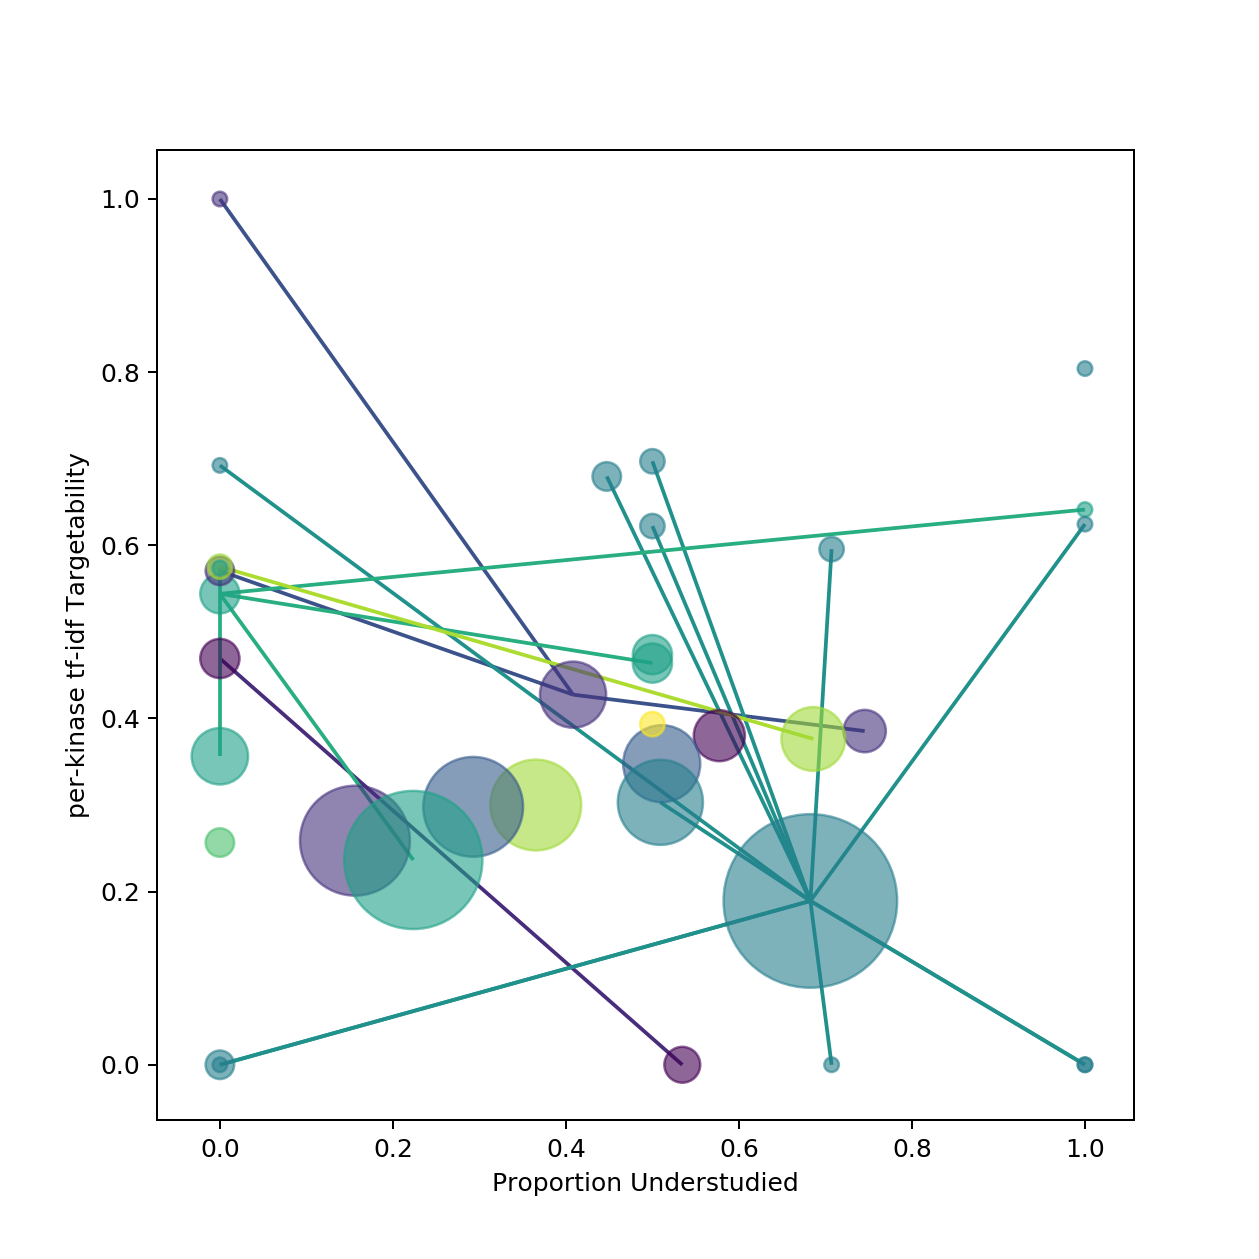

In [269]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))

under_prop = copy(subcluster_data['understudied']/subcluster_data['names'])
tfidf_clust = copy(subcluster_data['drug_score']/subcluster_data['names'])

## standardize
#under_prop = (under_prop - np.mean(under_prop))/np.std(under_prop)
#tfidf_clust = (tfidf_clust - np.mean(tfidf_clust))/np.std(tfidf_clust)

## normalize
#under_prop = (under_prop - np.min(under_prop))/(np.max(under_prop)- np.min(under_prop))
tfidf_clust = (tfidf_clust - np.min(tfidf_clust))/(np.max(tfidf_clust)- np.min(tfidf_clust))

## variance stabilize
under_prop = np.sqrt(under_prop)
tfidf_clust = np.sqrt(tfidf_clust)


plt.scatter(x=under_prop, y=tfidf_clust, s=subcluster_data['names'].apply(lambda x: (np.log(x)+1)*x*10), c=subcluster_data['cluster_super'], alpha=.6, zorder=1)
plt.xlabel('Proportion Understudied')
plt.ylabel('per-kinase tf-idf Targetability')
#ax.set_yscale("log", basey=2)#, nonposy='clip')
#plt.ylim([-2,4])
#plt.yticks([0,.25,.5,1])

for sup_ in set(subcluster_data.cluster_super.unique()):
    points_of_interest = list(zip(under_prop[subcluster_data.cluster_super == sup_], tfidf_clust[subcluster_data.cluster_super == sup_]))
    num_pres = len(points_of_interest)
    connect_to = min(1, num_pres-1)

    dist = squareform(pdist(points_of_interest, 'euclidean'))
    neighbors = np.sort(np.argsort(dist, axis=1)[:, 0:])

    points_added = set()
    coordinates = np.zeros((num_pres, connect_to, 2, 2))
    for i in range(0, num_pres):
        for j in range(0, connect_to):
            next_add = j
            if(points_of_interest[neighbors[i, next_add]][0]) in points_added:
                next_add += 1
                
            coordinates[i, j, :, 0] = np.array([points_of_interest[i][0], points_of_interest[neighbors[i, next_add]][0]])
            coordinates[i, j, :, 1] = np.array([points_of_interest[i][1], points_of_interest[neighbors[i, next_add]][1]])
            
            points_added = points_added | set([points_of_interest[neighbors[i, j]][0], points_of_interest[neighbors[i, j]][1]])
            

    # create line artists
    lines = LineCollection(coordinates.reshape((num_pres*connect_to, 2, 2)), color=cm.viridis(sup_/8.0), zorder=-1)

    ax.add_collection(lines)

#plt.yscale('logit')
#plt.xscale('logit')

#plt.autoscale()
#plt.xlim([-1,2])
#plt.ylim([-1,2])
plt.show()

<IPython.core.display.Javascript object>


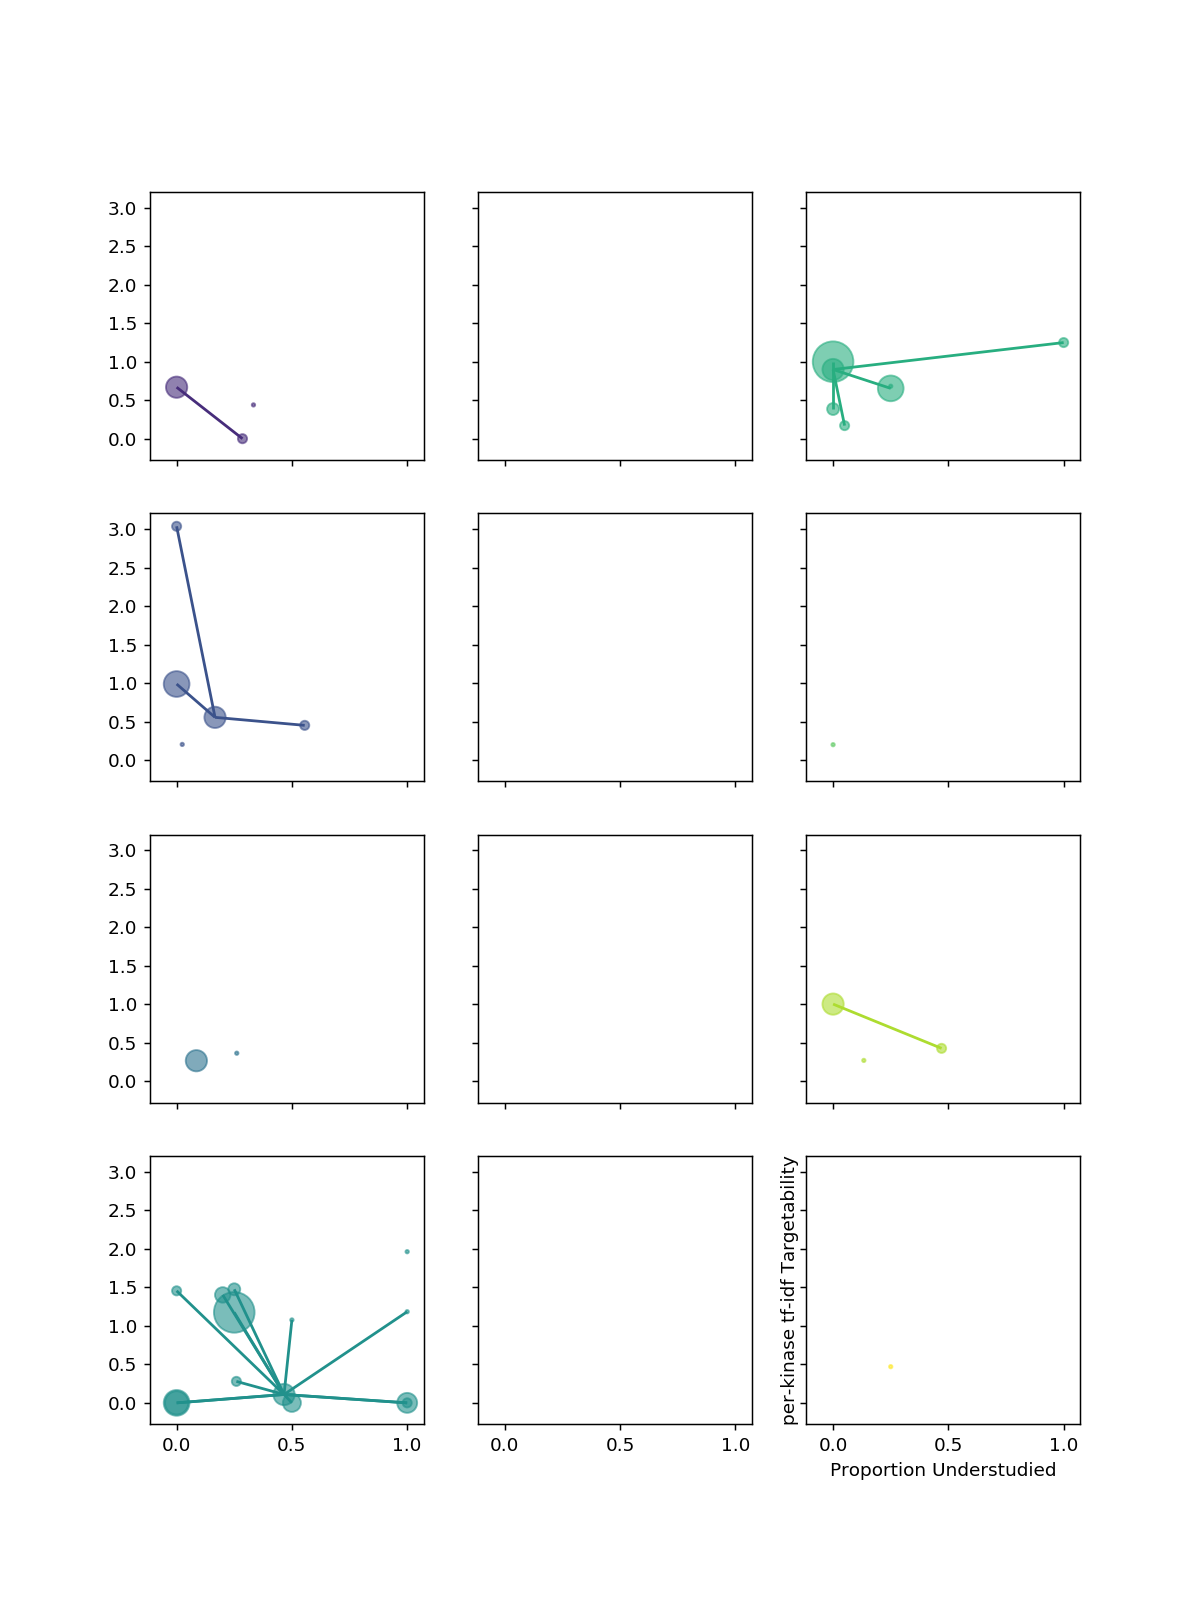

In [284]:
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(9,12), sharex=True, sharey=True)
#fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))

under_prop = copy(subcluster_data['understudied']/subcluster_data['names'])
tfidf_clust = copy(subcluster_data['drug_score']/subcluster_data['names'])

## standardize
#under_prop = (under_prop - np.mean(under_prop))/np.std(under_prop)
#tfidf_clust = (tfidf_clust - np.mean(tfidf_clust))/np.std(tfidf_clust)

## normalize
#under_prop = (under_prop - np.min(under_prop))/(np.max(under_prop)- np.min(under_prop))
#tfidf_clust = (tfidf_clust - np.min(tfidf_clust))/(np.max(tfidf_clust)- np.min(tfidf_clust))

## variance stabilize
#under_prop = np.sqrt(under_prop)
#tfidf_clust = np.sqrt(tfidf_clust)

for sup_, ax in zip(range(1,9), list(axes[:,0])+list(axes[:,2])):
    ax.scatter(x=under_prop[subcluster_data.cluster_super == sup_], y=tfidf_clust[subcluster_data.cluster_super == sup_], s=subcluster_data['names'].apply(lambda x: (np.log(x)+1)*x), c=cm.viridis(sup_/8.0), alpha=.6, zorder=1)
    plt.xlabel('Proportion Understudied')
    plt.ylabel('per-kinase tf-idf Targetability')
    #ax.set_yscale("log", basey=2)#, nonposy='clip')
    #plt.ylim([-2,4])
    #plt.yticks([0,.25,.5,1])


    points_of_interest = list(zip(under_prop[subcluster_data.cluster_super == sup_], tfidf_clust[subcluster_data.cluster_super == sup_]))
    num_pres = len(points_of_interest)
    connect_to = min(1, num_pres-1)

    dist = squareform(pdist(points_of_interest, 'euclidean'))
    neighbors = np.sort(np.argsort(dist, axis=1)[:, 0:])

    points_added = set()
    coordinates = np.zeros((num_pres, connect_to, 2, 2))
    for i in range(0, num_pres):
        for j in range(0, connect_to):
            next_add = j
            while(points_of_interest[neighbors[i, next_add]][0]) in points_added:
                next_add += 1

            coordinates[i, j, :, 0] = np.array([points_of_interest[i][0], points_of_interest[neighbors[i, next_add]][0]])
            coordinates[i, j, :, 1] = np.array([points_of_interest[i][1], points_of_interest[neighbors[i, next_add]][1]])

            points_added = points_added | set([points_of_interest[neighbors[i, j]][0], points_of_interest[neighbors[i, j]][1]])


    # create line artists
    lines = LineCollection(coordinates.reshape((num_pres*connect_to, 2, 2)), color=cm.viridis(sup_/8.0), zorder=-1)

    ax.add_collection(lines)

    #plt.yscale('logit')
    #plt.xscale('logit')

    #plt.autoscale()
    #plt.xlim([-1,2])
    #plt.ylim([-1,2])
    
plt.show()

### New plots

In [292]:
louv.head()

names  cluster_super  cluster_sub  \
0   PAK1              5            3   
1  ERBB2              5           18   
2  MST1R              5           18   
3   YES1              5           18   
4  TYRO3              5           18   

                                                Drug  understudied  
0                                                NaN         False  
1                                                NaN         False  
2  [Golvatinib, Crizotinib, Foretinib, MK-2461, O...         False  
3  [TG-100572, Dasatinib, TAK-901, Ibrutinib, Dan...         False  
4                                                NaN         False

In [331]:
drug_super_hits = defaultdict(Counter)

In [334]:
drug_super_hits['people'].update([5])

In [336]:
#drug_pivot = 
from collections import Counter
from collections import defaultdict
drug_counter = Counter([])


for i, row in louv.iterrows():
    drug_list = row.Drug
    if drug_list is not np.nan:
        # update the superclusters seen
        # update the drug counts for each drug
        for d in set(drug_list):
            drug_super_hits[d].update([row.cluster_super])
            drug_counter.update([d])

In [338]:
drug_super_hits

defaultdict(collections.Counter,
            {'people': Counter({5: 1}),
             'OTS-167': Counter({5: 25, 2: 10, 4: 26, 3: 24, 7: 10, 1: 4}),
             'Barasertib': Counter({5: 6, 2: 2, 3: 2, 4: 1}),
             'Milciclib': Counter({5: 21, 2: 7, 3: 15, 4: 26, 7: 5, 1: 1}),
             'XL-228': Counter({5: 29, 2: 7, 3: 7, 4: 16, 7: 4, 1: 4}),
             'Crizotinib': Counter({5: 12, 3: 6, 1: 1, 2: 3, 4: 3}),
             'Cyc-116': Counter({5: 18, 2: 10, 7: 5, 1: 5, 3: 17, 4: 30}),
             'Fostamatinib': Counter({5: 3, 3: 4, 7: 1, 4: 6, 2: 3}),
             'MK-2461': Counter({5: 1, 3: 4, 2: 1}),
             'Golvatinib': Counter({5: 18, 2: 4, 3: 6, 7: 1, 8: 1, 4: 2}),
             'Gilteritinib': Counter({5: 14, 2: 5, 7: 6, 3: 14, 1: 3, 4: 13}),
             'Rebastinib': Counter({5: 19, 2: 8, 3: 15, 7: 4, 4: 11}),
             'MK-8033': Counter({5: 2}),
             'MGCD-265': Counter({5: 11, 2: 4, 7: 1, 4: 2}),
             'Foretinib': Counter({5: 21, 2: 7,

In [337]:
drug_counter

Counter({'OTS-167': 99,
         'Barasertib': 11,
         'Milciclib': 75,
         'XL-228': 67,
         'Crizotinib': 25,
         'Cyc-116': 85,
         'Fostamatinib': 17,
         'MK-2461': 6,
         'Golvatinib': 32,
         'Gilteritinib': 55,
         'Rebastinib': 57,
         'MK-8033': 2,
         'MGCD-265': 18,
         'Foretinib': 38,
         'PF-03814735': 72,
         'Barasertib_HQPA': 11,
         'PF-3758309': 73,
         'PF-477736': 49,
         'Ponatinib': 45,
         'Saracatinib': 38,
         'AEW-541': 22,
         'Danusertib': 65,
         'TG-100801': 12,
         'Bosutinib': 39,
         'BMS-690514': 47,
         'AZD-7762': 61,
         'ASP-3026': 36,
         'Dovitinib': 49,
         'ENMD-2076': 20,
         'Sunitinib': 60,
         'Varlitinib': 4,
         'AV-412': 7,
         'Tesevatinib': 31,
         'TAK-593': 9,
         'Dasatinib': 65,
         'AEE-788': 23,
         'Ibrutinib': 22,
         'CP-547632': 28,
         'TG-1

In [359]:
set(louv.cluster_super.unique())

{1, 2, 3, 4, 5, 6, 7, 8}

In [366]:
drug_super_hit_normalizer

{1: Counter({'Orantinib': 1,
          'XL-228': 4,
          'SGI-1776': 1,
          'KW-2449': 1,
          'TG-100801': 1,
          'BMS-690514': 1,
          'OTS-167': 4,
          'Cediranib': 1,
          'Cerdulatinib': 1,
          'ENMD-2076': 1,
          'Vemurafenib': 1,
          'Dasatinib': 4,
          'MK-5108': 3,
          'TG-100572': 3,
          'AT-9283': 8,
          'Nintedanib': 2,
          'OSI-027': 2,
          'Ponatinib': 1,
          'AEW-541': 2,
          'RGB-286638': 1,
          'GDC-0994': 1,
          'RDEA-436': 1,
          'Milciclib': 1,
          'Lestaurtinib': 4,
          'Crizotinib': 1,
          'Pacritinib': 1,
          'Silmitasertib': 1,
          'TAK-901': 2,
          'Galunisertib': 2,
          'Saracatinib': 5,
          'Sapanisertib': 6,
          'Danusertib': 4,
          'Gilteritinib': 3,
          'ASP-3026': 1,
          'AZD-7762': 1,
          'SCH-900776': 1,
          'Sunitinib': 1,
          'AEE-788': 1,
   

In [365]:
drug_set = list(set(drug_data.Drug))
drug_hit_array = [drug_counter[d] for d in drug_set]
drug_super_hit_dict_array = {sup_:[drug_super_hits[d][sup_] for d in drug_set] for sup_ in set(louv.cluster_super.unique())}

drug_super_hit_normalizer = {sup_:Counter() for sup_ in set(louv.cluster_super.unique())}

for i,d in enumerate(drug_set):
    for sup_ in louv.cluster_super.unique():
        for val in range(0, drug_super_hit_dict_array[sup_][i]):
            drug_super_hit_normalizer[sup_].update([d])

In [346]:
np.min(drug_hit_array)

1

In [371]:
drug_super_hit_normalizer[sup_]

Counter({'Orantinib': 3,
         'XL-228': 29,
         'SGI-1776': 4,
         'Ulixertinib': 1,
         'Masitinib': 5,
         'Afatinib': 1,
         'P-276-00': 1,
         'Volasertib': 1,
         'KW-2449': 9,
         'PF-562271': 6,
         'Barasertib': 6,
         'Alvocidib': 4,
         'Vatalanib': 1,
         'MLN-2480': 9,
         'ACTB-1003': 4,
         'TG-100801': 8,
         'BMS-690514': 18,
         'Barasertib_HQPA': 5,
         'OTS-167': 25,
         'Cediranib': 9,
         'XL-019': 6,
         'Tivantinib': 1,
         'Cerdulatinib': 6,
         'ENMD-2076': 8,
         'Ruxolitinib': 5,
         'R-406': 3,
         'SB-1317': 4,
         'Enzastaurin': 1,
         'Entrectinib': 1,
         'Vemurafenib': 2,
         'TAK-593': 7,
         'Crenolanib': 5,
         'Rigosertib': 1,
         'Dasatinib': 29,
         'Y-39983': 7,
         'MK-5108': 11,
         'Tivozanib': 13,
         'TG-100572': 15,
         'BI-847325': 16,
         'AMG-208'

In [375]:
drug_super_hit_dict_array[sup_]*np.array([drug_super_hit_normalizer[sup_][d] for d in drug_set])/counts_normalized

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.

In [388]:
drug_super_hit_dict_array[sup_]*np.array([drug_super_hit_normalizer[sup_][d] for d in drug_set])/counts_normalized

array([ 0.39130435, 12.55223881,  1.14285714,  0.        ,  0.25      ,
        0.        ,  4.16666667,  0.        ,  0.14285714,  0.11111111,
        0.25      ,  1.65306122,  0.9       ,  3.27272727,  0.        ,
        0.        ,  0.66666667,  1.        ,  4.26315789,  0.        ,
        1.14285714,  5.33333333,  6.89361702,  2.27272727,  6.31313131,
        5.78571429,  1.56521739,  1.        ,  0.7826087 ,  3.2       ,
        1.19047619,  0.47368421,  0.        ,  0.53333333,  0.2       ,
        0.33333333,  0.44444444,  5.44444444,  0.54347826,  0.        ,
        1.        , 12.93846154,  0.        ,  1.96      ,  4.32142857,
        8.04761905,  8.03571429,  5.68888889,  1.        ,  6.18811881,
        2.18918919,  0.25      ,  0.66666667,  1.        ,  0.        ,
        0.33333333,  0.25      ,  0.16666667,  2.77777778,  0.5       ,
        0.        ,  1.        ,  1.        ,  3.27272727,  0.44444444,
        0.        ,  0.8       ,  0.        ,  0.33333333,  8.88

<IPython.core.display.Javascript object>


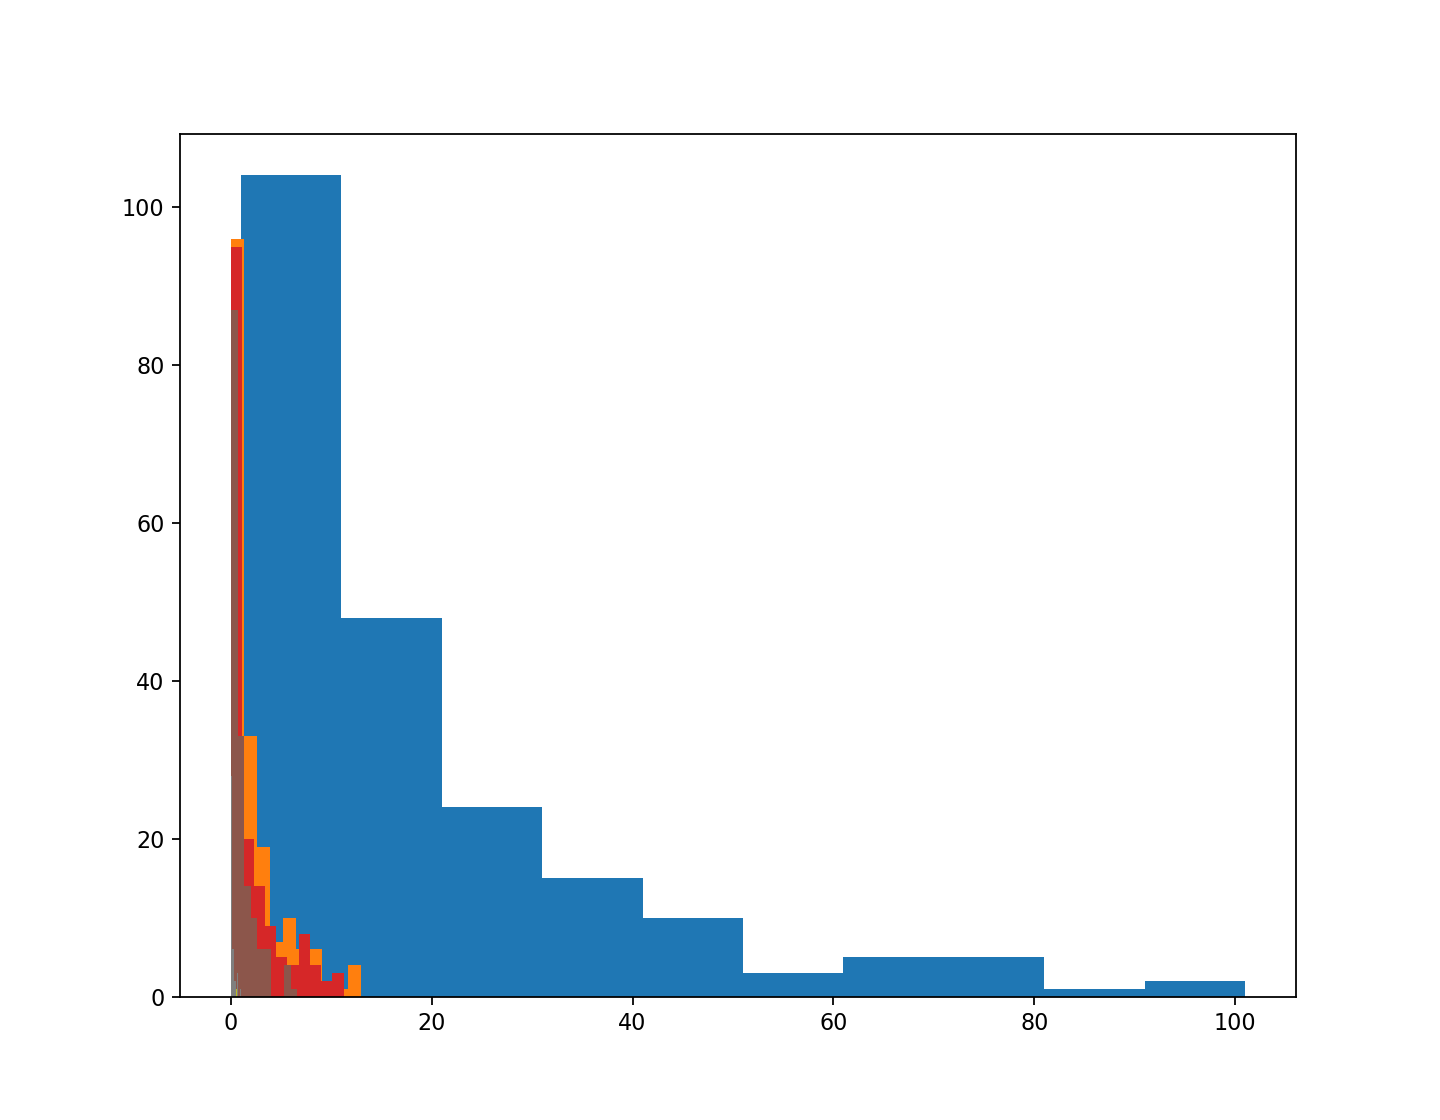

In [389]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,7))
plt.hist(drug_hit_array)
for sup_ in louv.cluster_super.unique():
    counts_normalized = np.ones_like(drug_hit_array)
    counts_normalized = np.maximum(drug_hit_array, counts_normalized)
    plt.hist(list(filter(lambda x: x > 0 ,drug_super_hit_dict_array[sup_]*np.array([drug_super_hit_normalizer[sup_][d] for d in drug_set])/counts_normalized)))
#plt.xlim([-1,120])

In [393]:
drug_super_hit_dict_array[sup_]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [405]:
np.max(drug_hit_array)

101

<IPython.core.display.Javascript object>


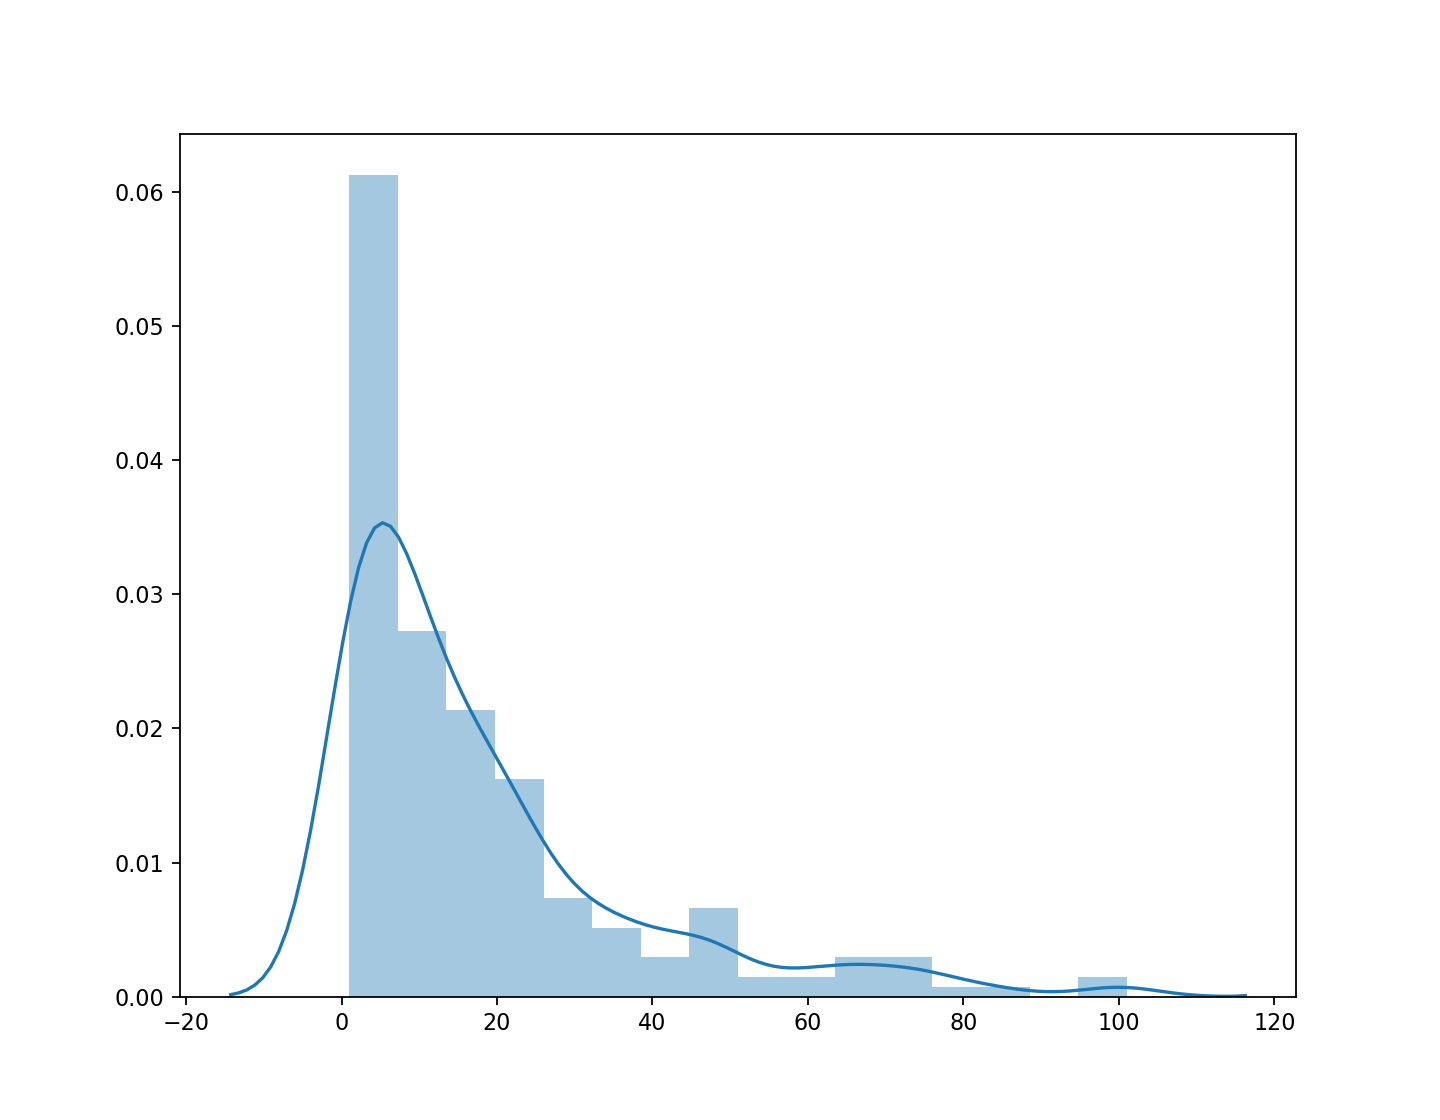

In [404]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,7))
sns.distplot(drug_hit_array)
plt.show()

<IPython.core.display.Javascript object>


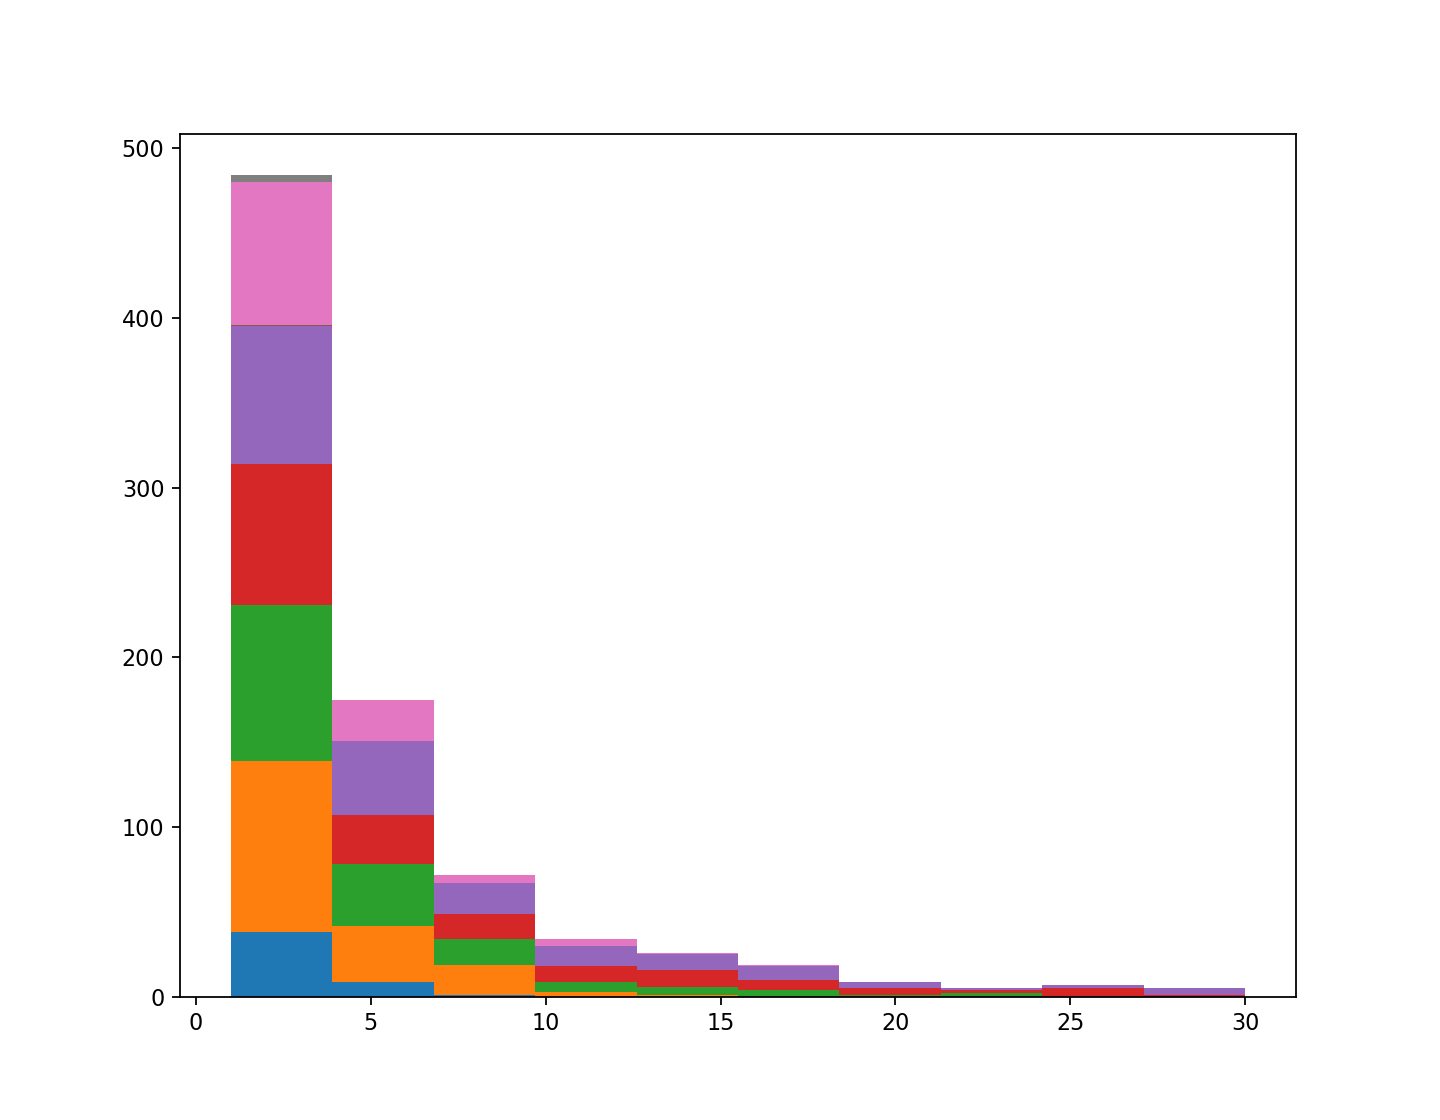

([array([38.,  9.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([139.,  42.,  19.,   3.,   1.,   0.,   0.,   0.,   0.,   0.]),
  array([231.,  78.,  34.,   9.,   6.,   4.,   1.,   2.,   0.,   0.]),
  array([314., 107.,  49.,  18.,  16.,  10.,   5.,   4.,   5.,   1.]),
  array([395., 151.,  67.,  30.,  25.,  18.,   9.,   5.,   7.,   5.]),
  array([396., 151.,  67.,  30.,  25.,  18.,   9.,   5.,   7.,   5.]),
  array([480., 175.,  72.,  34.,  26.,  19.,   9.,   5.,   7.,   5.]),
  array([484., 175.,  72.,  34.,  26.,  19.,   9.,   5.,   7.,   5.])],
 array([ 1. ,  3.9,  6.8,  9.7, 12.6, 15.5, 18.4, 21.3, 24.2, 27.1, 30. ]),
 <a list of 8 Lists of Patches objects>)

In [401]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,7))
plt.hist([list(filter(lambda x: x >0, drug_super_hit_dict_array[sup_])) for sup_ in set(louv.cluster_super.unique())], stacked=True)
#plt.semilogy()

In [408]:
drug_cross_super = pd.DataFrame([drug_super_hit_dict_array[sup_] for sup_ in set(louv.cluster_super.unique())])

In [413]:
louv['num_drugs'] = louv.Drug.apply(lambda x: len(x) if x is not np.nan else 0)
louv.head()

names  cluster_super  cluster_sub  \
0   PAK1              5            3   
1  ERBB2              5           18   
2  MST1R              5           18   
3   YES1              5           18   
4  TYRO3              5           18   

                                                Drug  understudied  num_drugs  
0                                                NaN         False          0  
1                                                NaN         False          0  
2  [Golvatinib, Crizotinib, Foretinib, MK-2461, O...         False         16  
3  [TG-100572, Dasatinib, TAK-901, Ibrutinib, Dan...         False         31  
4                                                NaN         False          0

<IPython.core.display.Javascript object>


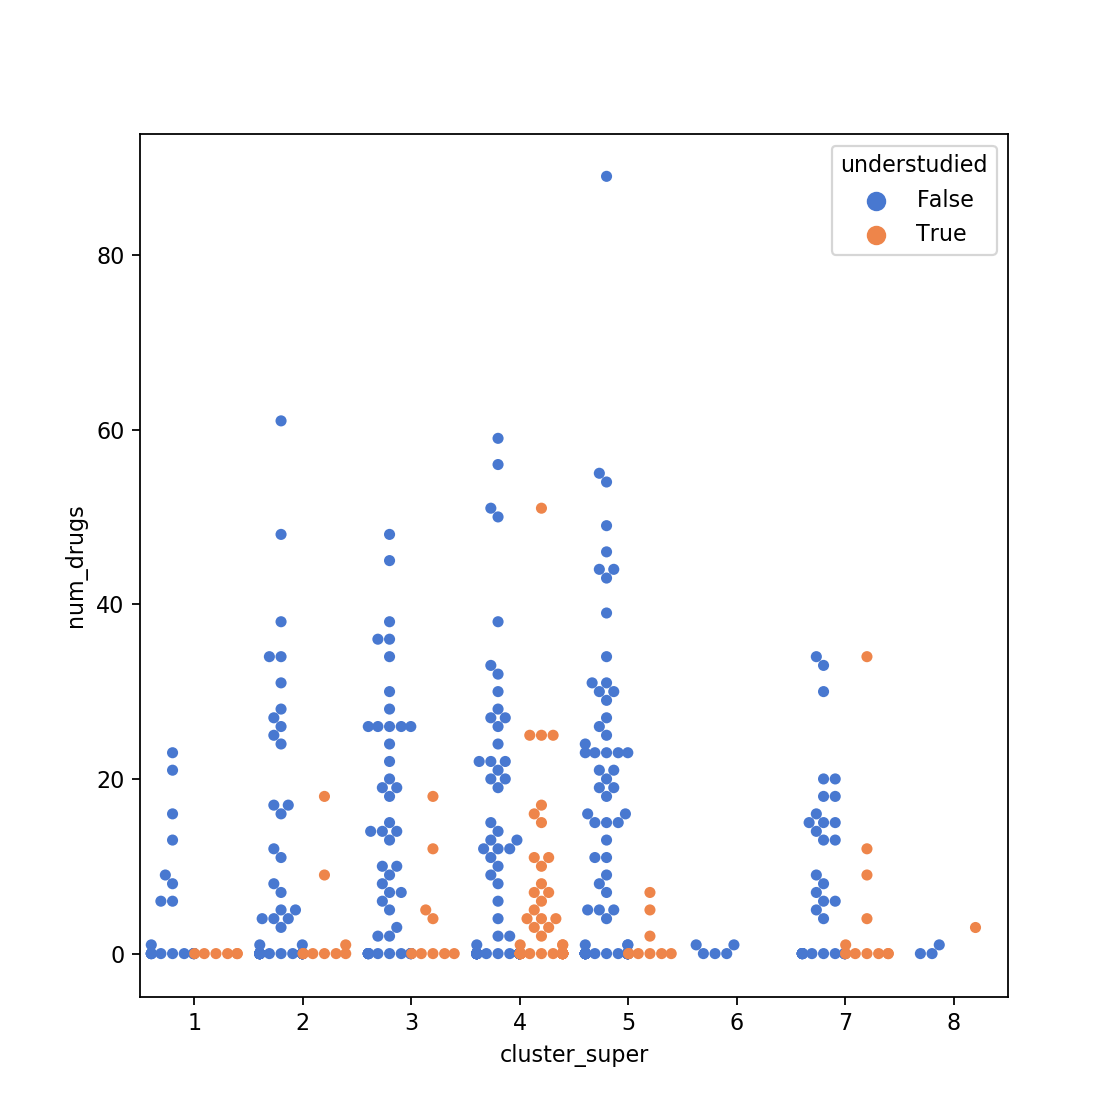

In [422]:
plt.figure(figsize=(7,7))
ax = sns.swarmplot(x='cluster_super', y="num_drugs", hue="understudied", data=louv, palette="muted", dodge=True)

<IPython.core.display.Javascript object>


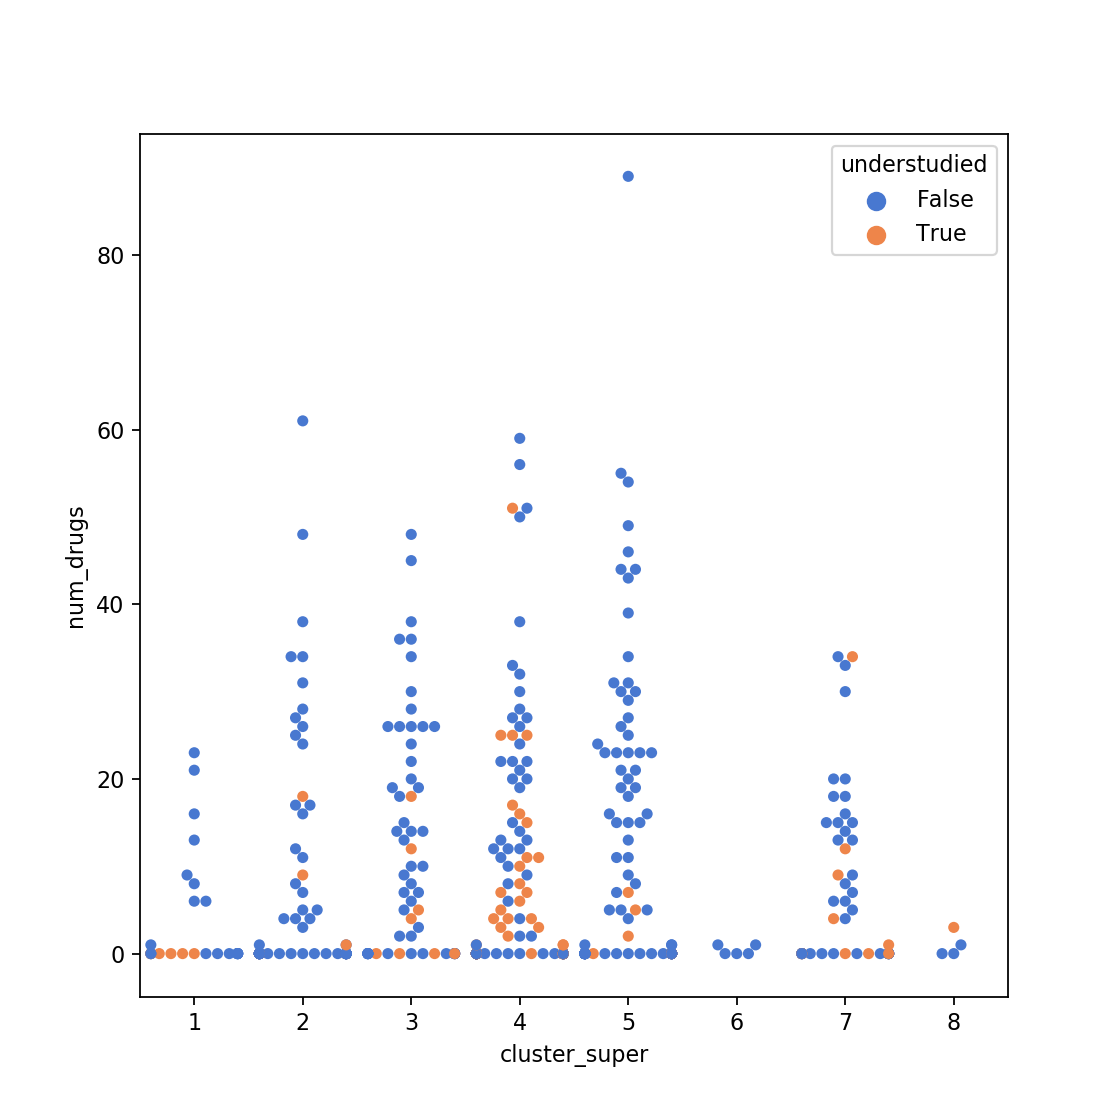

In [427]:
plt.figure(figsize=(7,7))
ax = sns.swarmplot(x='cluster_super', y="num_drugs", hue="understudied", data=louv, palette="muted")

In [428]:
drug_counter

Counter({'OTS-167': 99,
         'Barasertib': 11,
         'Milciclib': 75,
         'XL-228': 67,
         'Crizotinib': 25,
         'Cyc-116': 85,
         'Fostamatinib': 17,
         'MK-2461': 6,
         'Golvatinib': 32,
         'Gilteritinib': 55,
         'Rebastinib': 57,
         'MK-8033': 2,
         'MGCD-265': 18,
         'Foretinib': 38,
         'PF-03814735': 72,
         'Barasertib_HQPA': 11,
         'PF-3758309': 73,
         'PF-477736': 49,
         'Ponatinib': 45,
         'Saracatinib': 38,
         'AEW-541': 22,
         'Danusertib': 65,
         'TG-100801': 12,
         'Bosutinib': 39,
         'BMS-690514': 47,
         'AZD-7762': 61,
         'ASP-3026': 36,
         'Dovitinib': 49,
         'ENMD-2076': 20,
         'Sunitinib': 60,
         'Varlitinib': 4,
         'AV-412': 7,
         'Tesevatinib': 31,
         'TAK-593': 9,
         'Dasatinib': 65,
         'AEE-788': 23,
         'Ibrutinib': 22,
         'CP-547632': 28,
         'TG-1

In [452]:
for x,y in super_drug_num_hit.items():
    print(x,y)
    break

(1, 'AEE-788') 1


In [437]:
selectivity_catter = lambda x: 0 if drug_counter[x] < 40 else 1 if drug_counter[x] < 60 else 2 if drug_counter[x] < 80 else 3

In [456]:
drug_data.head()

Target        Drug        At     CATDS  cluster_super  understudied  \
0     AURKA     MK-5108  0.120921  0.657165              4         False   
1     CHEK1   PF-477736  0.243725  0.733257              4         False   
2      FLT3   Dovitinib  0.265240  0.860803              2         False   
4       MET  Capmatinib  0.337514  1.000000              5         False   
5  MAPKAPK2      VX-702  0.342705  0.743594              3         False   

   selectivity_score  num_members_hit  
0                  0                6  
1                  1               14  
2                  1                6  
4                  0                1  
5                  0                3

In [438]:
super_mapper = louv.set_index('names')['cluster_super'].to_dict()
drug_data['cluster_super'] = drug_data.Target.apply(lambda x: super_mapper[x])
drug_data['understudied'] = drug_data.Target.isin(understudied.symbol)
drug_data['selectivity_score'] = drug_data.Drug.apply(selectivity_catter)

super_drug_num_hit = drug_data.groupby(['cluster_super', 'Drug'])['Target'].agg(len).to_dict()
super_drug_num_hit = {x:{y[1]:z for y, z in super_drug_num_hit.items() if y[0]==x} for x in set(louv.cluster_super.unique())}



In [455]:
drug_data['num_members_hit'] = [super_drug_num_hit[x][y] for x,y in zip(drug_data.cluster_super, drug_data.Drug)]

In [468]:
drug_data['cluster_super'] = drug_data['cluster_super'] / 10

In [497]:
np.random.rand()-.5

0.05863707208362723

In [498]:
drug_data['num_members_hit'] = drug_data['num_members_hit'].apply(lambda x: x + np.random.rand()-.5)

<IPython.core.display.Javascript object>


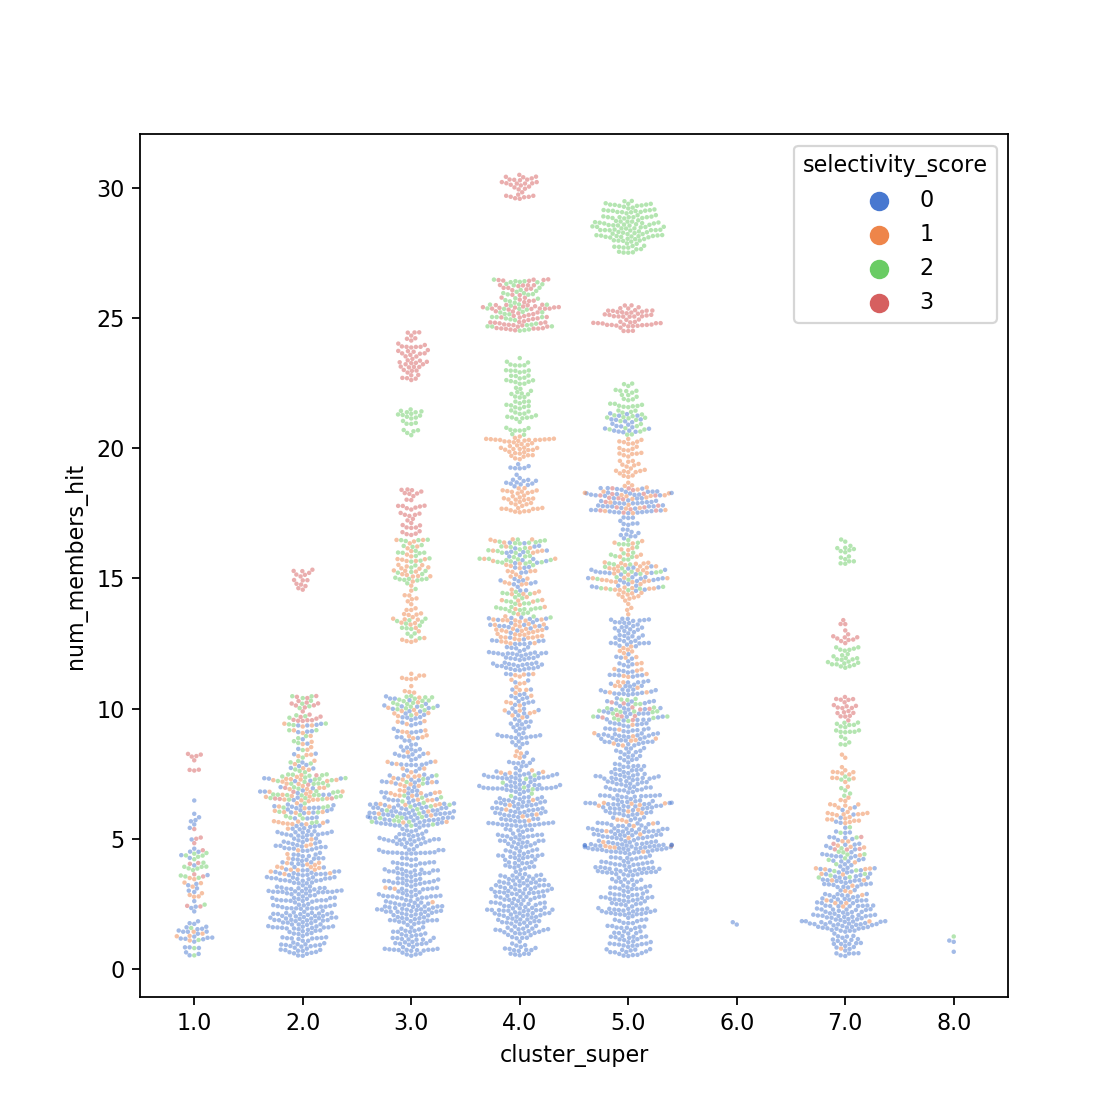

In [500]:
plt.figure(figsize=(7,7))
ax = sns.swarmplot(x='cluster_super', y='num_members_hit', hue="selectivity_score", data=drug_data, palette="muted", size=2, orient='v', alpha = .5)